# Spaceship.

## Task description

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## Files and Data Fields Descriptions


### **train.csv**  - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

Your task is to predict the value of Transported for the passengers in this set.

### **sample_submission.csv** - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False.



### Here are the first 5 rows of the data:

In [3]:
import pandas as pd
import numpy as np

# Random seed for reproducibility
SEED = 123
# A file to save global variables
global_variables = pd.DataFrame({'SEED': [SEED]})
global_variables.to_csv('global_variables.csv')
global_variables.to_csv('functions/global_variables.csv')

train_unprocessed = pd.read_csv('datasets/train.csv')
test_unprocessed = pd.read_csv('datasets/test.csv')

train_size = len(train_unprocessed)
train_size_file = pd.DataFrame([train_size])
train_size_file.to_csv('train_size.csv')

# Collect Passenger Ids in the test dataset into a separate variable
test_Ids = test_unprocessed['PassengerId']
test_Ids.to_csv('test_Ids.csv')

data_unprocessed = pd.concat([train_unprocessed, test_unprocessed]).reset_index(drop=True)

data_unprocessed.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
data_unprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


## 00. Baseline

First, we'll make a baseline prediction, that all passengers were Transported. We'll calculate the Score of this prediction on the train set (for future cases, we'll calculate separately Train Score and Cross-validation Score, but in this case, these scores will be equal to Train Score, since our cross-validation will be stratified).

Our Score = (Average Cross-validation ROC AUC) - (1 Standard deviation of Cross-validation ROC AUCs).

In this simple case, Standard deviation will be 0 (again, cross-validation is stratified), so Score for this case will be just Train ROC AUC.

We'll save our intermediate results in DataFrame scores_df:

In [5]:
from sklearn.metrics import roc_auc_score

train_predictions_00 = pd.DataFrame(data=train_unprocessed['Transported'], columns=['Transported'])
train_predictions_00['Transported'] = True

scores_df = pd.DataFrame({'Comment': [], 'Train Score': [], 'Cross-val Score': [], 'Test Accuracy': []})

score_00 = roc_auc_score(train_unprocessed['Transported'], train_predictions_00['Transported'])

scores_df.loc[0, 'Comment'] = 'All True'
scores_df.loc[0, 'Train Score'] = score_00
scores_df.loc[0, 'Cross-val Score'] = score_00
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.5,0.5,NaN


ROC AUC is 0.5, which means our predictions are no better than random guessing

Now, we'll make a submission to Kaggle to see our Test Accuracy. We won't use Test Accuracy in making decisions, but we'll use it to catch bugs in our Score calculations:

In [6]:
test_predictions_00 = pd.DataFrame([True] * len(test_unprocessed), columns=['Transported'])
submission_00 = pd.concat([test_unprocessed['PassengerId'], test_predictions_00], axis=1)

submission_00.to_csv('submissions/submission_00.csv', index=False)

scores_df.loc[0, 'Test Accuracy'] = 0.50689
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.5,0.5,0.50689


## 01. Numerical features with 0's for missing values

Now, we'll make predictions on the numerical features only, filling missing values with zeros:

In [7]:
# Drop non-numerical columns
train = train_unprocessed.select_dtypes(include=['int', 'float'])
test = test_unprocessed.select_dtypes(include=['int', 'float'])

# Put the target variable back to the train dataset
train = pd.concat([train, train_unprocessed['Transported']], axis=1)

# Fill missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

train.to_csv('new_datasets/train_01.csv')
test.to_csv('new_datasets/test_01.csv')


We'll use XGBoost with default parameters as our first estimator. 

### Choosing number of cross-validation splits

For calculating Score, I wrote get_score function, that is located in ['functions/get_score.py'](functions/get_score.py). This function takes a number of StratifiedKFold slits as one of its arguments. 

We want such number of splits that give us the best balance between bias and variance. For the sake of run time, the optimal number of splits calculation is done in a separate file: ['functions/n_splits.py'](functions/n_splits.py).

The tradeoff sweetspot is at 3 splits.

In [8]:
N_SPLITS = 3
global_variables['N_SPLITS'] = N_SPLITS
global_variables.to_csv('global_variables.csv')
global_variables.to_csv('functions/global_variables.csv')

Let's find Scores and Test Accuracy for this number of splits:

In [9]:
# UNCOMMENT TO INSTALL XGBOOST
#!pip install xgboost
import xgboost as xgb

# Instantiate the classifier
model = xgb.XGBClassifier(random_state=SEED, n_jobs=-1)

from functions.get_score import get_score

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train, test, model, scores_df,
                                                                  comment="All numerical features with 0's for missing values")

In [10]:
submission.to_csv('submissions/submission_01.csv', index=False)

scores_df.loc[1, 'Test Accuracy'] = 0.79027
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027


## Hyperparameters tuning workflow description

For the sake of runtime and for convinience, we'll do all our hyperparameters tunings in separate files. Here is the workflow:

-) Notice the Report chapter number. For example, our next chapter, in which we'll do our first tining, is 02.

-) If you need to restart any study from scratch, go to ['functions/initialize_studies.ipynb'](functions/initialize_studies.ipynb), run the first cell to import packages, then run a cell with your current Report chapter number. The progress of that study will be deleted.

!!!ATTENTION!!! Do not run the whole initialize_studies notebook, or all the studies will be restarted (unless that is what you want). !!!ATTENTION!!!

-) The current study is in studies/Report_chapter_number.py. For example, next study will be in ['studies/02.py'](studies/02.py).

-) At the beginning of the study file, choose maximum run time and number of trials for the current run.

-) Hyperparameter tuning will be continued from the end of the previous run of this file.

-) At the end of the run, look at the best parameters. If some of the parameters are on the extreme ends of the search ranges, extend the ranges. The study progress will be kept.

-) At the end of the run, look at the total number of trials in study and the number of the best trial.

-) If results (Average cross-val scores) keep going up, re-run the file. Repeat until satisfied.

-) If results (Average cross-val scores) do not improve for a big number of trials, then go back to the current Report chapter and load results (see below).

For a simple exaple look at ['studies/test.ipynb'](studies/test.ipynb). This study maximizes sum of two numbers chosen from a set of integers.

## 02. Choosing numerical features

We'll find the set of numerical features that gives us the highest cross-validation Score:

In [11]:
import joblib
import optuna

study = joblib.load("studies/02.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8284518468994545
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True}


Here, "'Age': True" means that the best model was using 'Age' feature. 

All the features were selected by our hyperparameters search.

Note, that our best Score is equal to the Score from the 01, since we used the same set of features and same random seed. Let's put this score into scores_df for consistency:

In [12]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train, test, model, scores_df,
                                                                  comment="All numerical features are selected")
scores_df.loc[2, 'Test Accuracy'] = 0.79027
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027


## Categorical features

Let's look at our data column by column:

## 03. Group Size

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

The number of a passenger within their group is arbitrary, so we don't need it. However, group numbers may be important, so we'll create a new feature "Group":

In [13]:
train['Group'] = train_unprocessed['PassengerId'].str[:4]
test['Group'] = test_unprocessed['PassengerId'].str[:4]
print(train['Group'].info())
print(train['Group'].describe())
print('Unique Values:')
print(train['Group'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Group
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count     8693
unique    6217
top       4498
freq         8
Name: Group, dtype: object
Unique Values:
['0001' '0002' '0003' ... '9278' '9279' '9280']


We have 6217 separate Groups in the training set among 8693 entries.

We need to transform Group to numerical features. Since the number of categories is high, it may be unworthy to create dummy variables. We'll try Mean Target Encoding (the fuctions for Mean Target Encoding are based on work by Yauhen Babakhin):

In [14]:
from functions.target_encoding import mean_target_encoding

# We'll need to express Transported as 1 and 0 for Mean Target Encoding:
train['Transported'] = [1 if i else 0 for i in train['Transported']]

# Encode Group
train['Group_enc'], test['Group_enc'] = mean_target_encoding(train, test, 'Transported', 'Group', alpha=7.5)

test['Group_enc'].describe()

count    4.277000e+03
mean     5.036236e-01
std      3.475404e-14
min      5.036236e-01
25%      5.036236e-01
50%      5.036236e-01
75%      5.036236e-01
max      5.036236e-01
Name: Group_enc, dtype: float64

Oh, it seems that we have only one unique value for the Group_enc in the test set:

In [15]:
test['Group_enc'].unique()

array([0.50362361])

The reason is that there is no Groups that are common between the train and test sets:

In [16]:
list(set(train['Group']) & set(test['Group']))

[]

Therefore, distinguishing Groups is useless. However, we can use the Group column in another way: let's calculate the number of group members and assign it to "GroupSize" variable:

In [17]:
train['GroupSize'] = train.groupby('Group')['Group'].transform('count')
test['GroupSize'] = test.groupby('Group')['Group'].transform('count')

for dataset in [train, test]:
    print(dataset['GroupSize'].info())
    print(dataset['GroupSize'].describe())
    print('Unique Values:')
    print(dataset['GroupSize'].unique())
    

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: GroupSize
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        2.035546
std         1.596347
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         8.000000
Name: GroupSize, dtype: float64
Unique Values:
[1 2 3 6 4 7 5 8]
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: GroupSize
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        1.997428
std         1.537113
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: GroupSize, dtype: float64
Unique Values:
[1 2 3 5 4 8 6 7]


Now, let's select features again, now with GroupSize feature as an option:

In [18]:
train.to_csv('new_datasets/train_03.csv')
test.to_csv('new_datasets/test_03.csv')

study = joblib.load("studies/03.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8342087175928439
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True, 'GroupSize': True}


We improved our Score by adding Group Size! Let's put results in the table:

In [19]:
# Create sets with selected columns

selected_columns = []
for key, value in study.best_params.items():
    if value:
        selected_columns.append(key)

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="+ GroupSize")
submission.to_csv('submissions/submission_03.csv', index=False)
scores_df.loc[3, 'Test Accuracy'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN


## Exploring missing values

PassengerId, and, therefore, GroupSize don't have missing values. Other columns, though, have missing values. Let's explore if there are some patterns in missing data:

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64


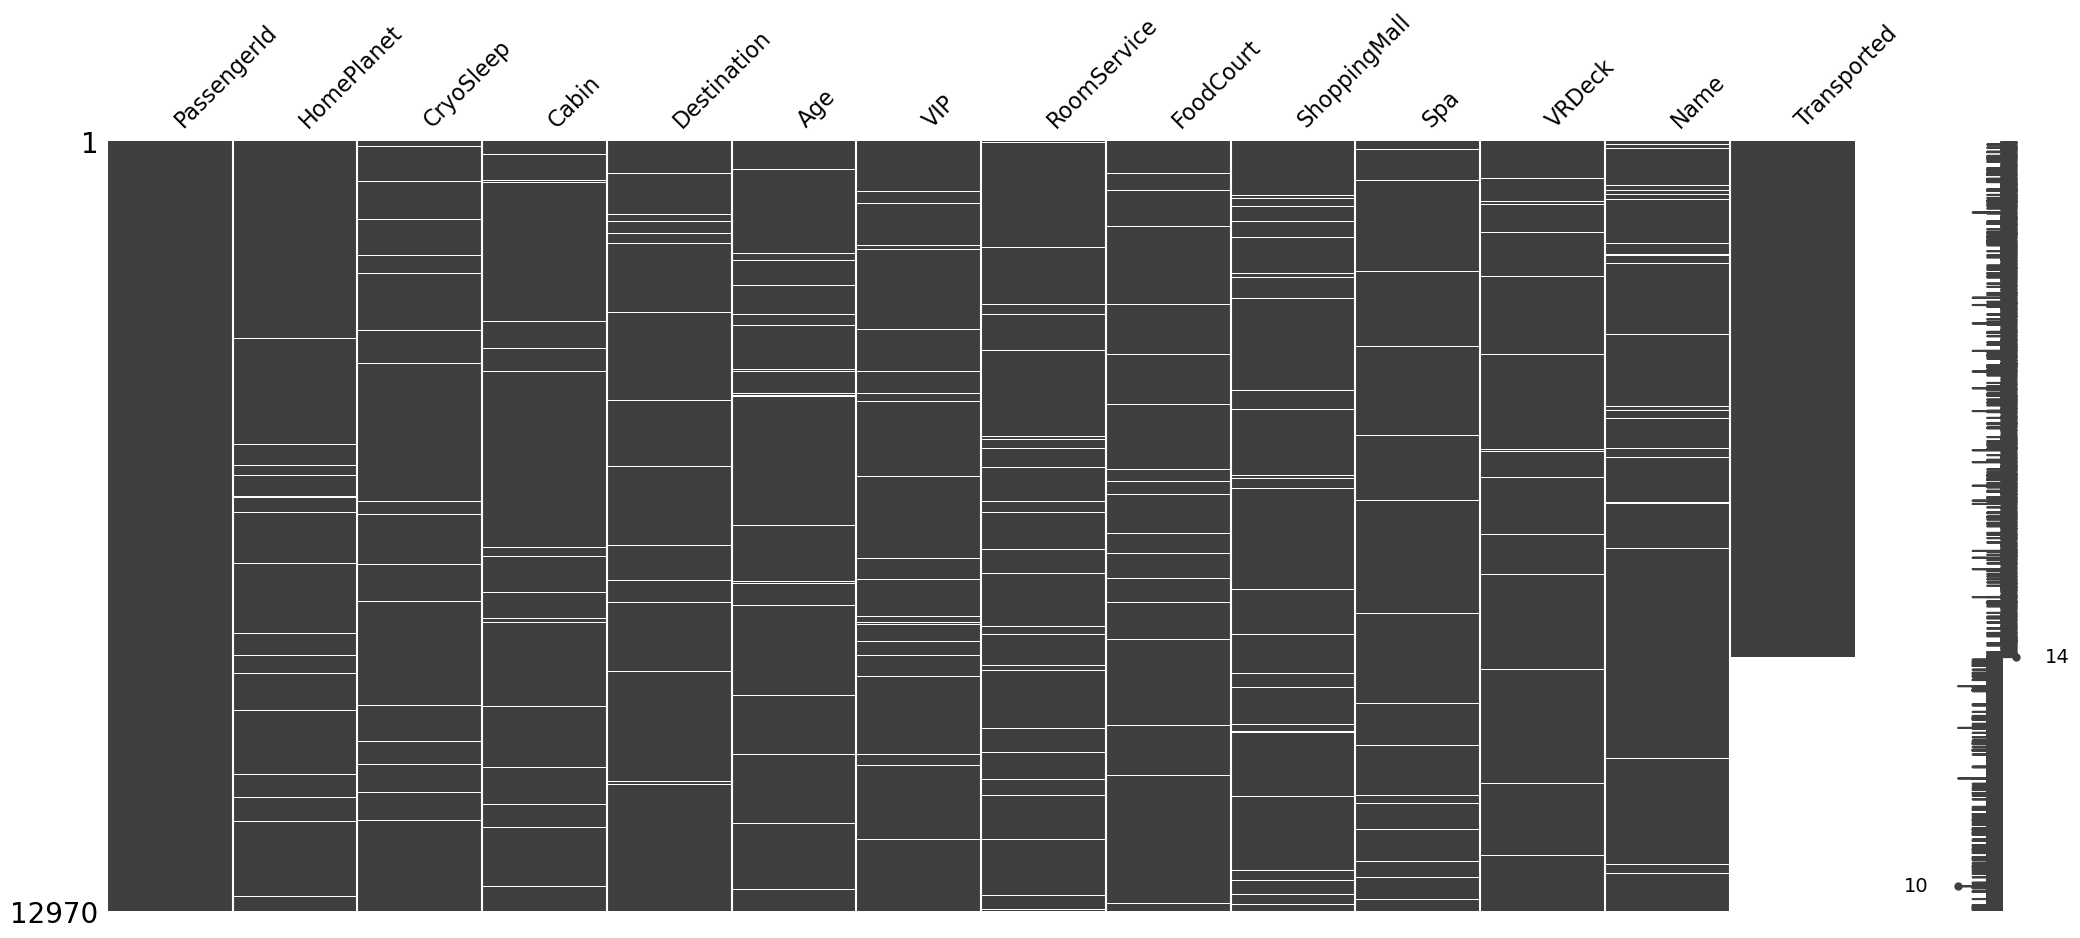

In [20]:
import missingno as msno
import matplotlib.pyplot as plt

# Print number of missing values in banking
print(data_unprocessed.isna().sum())

# Visualize missingness matrix
msno.matrix(data_unprocessed)
plt.show()

It seems that values are Missing At Random (Transported column is our target, it is missing in test data). We'll fill the missing values column by column, based on the description of the dataset.

## 04. Family Size

**Name** - The first and last names of the passenger.

We don't need the first names, so we'll strip them. 
Additionally, we may assume that passengers with the same last names in different Groups are not relatives. To avoid treating them as relatives, we will append Group names to all last names:

In [21]:
### !!!! FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

train = pd.concat([train, train_unprocessed['Name']], axis=1)
test = pd.concat([test, test_unprocessed['Name']], axis=1)

for data in [train, test]:
    data.Name = data.Name.str.split(' ', 1).str[1]
    data.Name = data.Name + data.Group

C:\Users\mikej\AppData\Local\Temp\ipykernel_39592\2091076608.py:7: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data.Name = data.Name.str.split(' ', 1).str[1]


We'll fill the missing values for Names based on the most common surname in their Group.
If a passenger is alone in their group, we'll name them by the name of their Group:

In [22]:
for data in [train, test]:
    # Iterate through all the rows with missing data
    for index in data[data['Name'].isna()].index:
        # Fill the missing values for lonely passengers:
        if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
            data.loc[index, "Name"] = data.loc[index, 'Group']
        # Fill the missing values for non-lonely passengers:
        else:
            data.loc[index, "Name"] = data[(data['Group'] == data.loc[index, 'Group']) & \
                    (data['Name'].isna() == False)]['Name'].mode()[0]

As you can see below, now Name doesn't have missing values:

In [23]:
for data in [train, test]:
    print(data['Name'].info())
    print(data['Name'].describe())
    print('Unique Values:')
    print(data['Name'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count               8693
unique              6491
top       Clemondsey9081
freq                   8
Name: Name, dtype: object
Unique Values:
['Ofracculy0001' 'Vines0002' 'Susent0003' ... 'Mondalley9278' 'Connon9279'
 'Hontichre9280']
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
4277 non-null   object
dtypes: object(1)
memory usage: 33.5+ KB
None
count          4277
unique         3200
top       Casez6332
freq              8
Name: Name, dtype: object
Unique Values:
['Carsoning0013' 'Peckers0018' 'Unhearfus0019' ... 'Pore9271' 'Conale9273'
 'Leonzaley9277']


Since we don't have common Groups between train and test, we don't have common families as well. Hence, we'll just create FamilySize feature:

In [24]:
for data in [train, test]:
    # Calculate FamilySize
    data['FamilySize'] = data.groupby('Name')['Name'].transform('count')
    print(data['FamilySize'].info())
    print(data['FamilySize'].describe())
    print('Unique Values:')
    print(data['FamilySize'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: FamilySize
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        1.819510
std         1.304256
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: FamilySize, dtype: float64
Unique Values:
[1 2 3 7 6 4 5 8]
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: FamilySize
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        1.771569
std         1.196133
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: FamilySize, dtype: float64
Unique Values:
[1 2 3 5 4 6 7 8]


Note, that GroupSize is not always equal to FamilySize:

In [25]:
(train['GroupSize'] - train['FamilySize']).value_counts()

0    7727
1     533
2     202
3      91
4      70
5      40
6      22
7       8
dtype: int64

In [26]:
(test['GroupSize'] - test['FamilySize']).value_counts()

0    3832
1     208
2      95
3      57
4      43
5      30
6       9
7       3
dtype: int64

Let's select features:

In [27]:
train.to_csv('new_datasets/train_04.csv')
test.to_csv('new_datasets/test_04.csv')

study = joblib.load("studies/04.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8342301402263921
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True, 'GroupSize': True, 'FamilySize': True}


In [28]:
# Create sets with selected columns

selected_columns = []
for key, value in study.best_params.items():
    if value:
        selected_columns.append(key)

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="+ FamilySize")
submission.to_csv('submissions/submission_04.csv', index=False)
scores_df.loc[4, 'Test Accuracy'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN


A small increase in Cross-val score, but still an increase.

## 05. The rest of categorical columns

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**Destination** - The planet the passenger will be debarking to.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

It makes sense that these three features depend on Group and Name, so we'll fill the missing values accordingly. For lonely passengers, we'll fill these columns with the most common values (in the train set, to avoud data leakage).

We have three unique cases where the whole group has missing values. We'll fill them first:

In [29]:
# Add unprocessed columns
for column in ['HomePlanet', 'Destination', 'VIP', 'Cabin', 'CryoSleep']:
    train = pd.concat([train, train_unprocessed[column]], axis=1)
    test = pd.concat([test, test_unprocessed[column]], axis=1)

# Handle special cases
train.loc[6917:6918, 'HomePlanet'] = train['HomePlanet'].mode()[0]
train.loc[5778:5779, 'VIP'] = train['VIP'].mode()[0]
test.loc[4248:4249, 'Cabin'] = test['Cabin'].mode()[0]

In [30]:
# List of columns with missing values
columns_to_fill = ['HomePlanet', 'Destination', 'VIP', 'Cabin']

# Iterate through all columns with missing values
for column in columns_to_fill:
    # For two datasets
    for data in [train, test]:
        # Iterate through all the rows with missing data
        for index in data[data[column].isna()].index:
            # Fill the missing values for passengers alone in their group:
            if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
                data.loc[index, column] = train[column].mode()[0]
             # Fill the missing values for passengers with an unique last name:
            elif len(data[data['Name'] == data.loc[index, 'Name']]) == 1:
                data.loc[index, column] = data[(data['Group'] == data.loc[index, 'Group']) & \
                    (data[column].isna() == False)][column].mode()[0]
            # Fill the missing values for non-lonely passengers:
            else:
                data.loc[index, column] = data[(data['Group'] == data.loc[index, 'Group']) & \
                                (data['Name'] == data.loc[index, 'Name']) & \
                                (data[column].isna() == False)][column].mode()[0]

Let's check the filled columns:

In [31]:
for column in columns_to_fill:
    for data in [train, test]:
        print(data[column].info())
        print(data[column].describe())
        print('Unique Values:')
        print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: HomePlanet
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count      8693
unique        3
top       Earth
freq       4745
Name: HomePlanet, dtype: object
Unique Values:
['Europa' 'Earth' 'Mars']
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: HomePlanet
Non-Null Count  Dtype 
--------------  ----- 
4277 non-null   object
dtypes: object(1)
memory usage: 33.5+ KB
None
count      4277
unique        3
top       Earth
freq       2326
Name: HomePlanet, dtype: object
Unique Values:
['Earth' 'Europa' 'Mars']
<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Destination
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count            8693
unique              3
top       TRAPPIST-1e
freq             6072
Name

Everything is good now, the first three columns are ready for encoding to numericals, but we want to extract the useful data from Cabin.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Let's extract Deck and Side:

In [32]:
for data in [train, test]:
    data['Deck'] = data.Cabin.str[0]
    data['Side'] = data.Cabin.str[-1]

for column in ['Deck', 'Side']:
    for data in [train, test]:
        print(data[column].info())
        print(data[column].describe())
        print('Unique Values:')
        print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Deck
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count     8693
unique       8
top          F
freq      2810
Name: Deck, dtype: object
Unique Values:
['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T']
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: Deck
Non-Null Count  Dtype 
--------------  ----- 
4277 non-null   object
dtypes: object(1)
memory usage: 33.5+ KB
None
count     4277
unique       8
top          F
freq      1458
Name: Deck, dtype: object
Unique Values:
['G' 'F' 'C' 'B' 'D' 'E' 'A' 'T']
<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Side
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count     8693
unique       2
top          S
freq      4442
Name: Side, dtype: object
Unique Values:
['P' 'S']
<cla

Seems great. We may assume that Decks are labeled based on their position in the spacehip, so we can label them with numbers:

In [33]:
# Label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

print('Deck encoding matches in train and test, see the first 10 rows:')
for data in [train, test]:
    data['Deck_enc'] = le.fit_transform(data['Deck'])
    print(data[['Deck', 'Deck_enc']].head(10))


Deck encoding matches in train and test, see the first 10 rows:
  Deck  Deck_enc
0    B         1
1    F         5
2    A         0
3    A         0
4    F         5
5    F         5
6    F         5
7    G         6
8    F         5
9    B         1
  Deck  Deck_enc
0    G         6
1    F         5
2    C         2
3    C         2
4    F         5
5    F         5
6    B         1
7    D         3
8    D         3
9    F         5


**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

I suspect that CryoSleep may be dependend on HomePlanet and Destination. Let's check:

In [34]:
print('Ratio of CryoSleep passengers per route:')
pd.pivot_table(train, values='CryoSleep', index=['HomePlanet'], columns=["Destination"])

Ratio of CryoSleep passengers per route:


Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,0.310443,0.506259,0.263781
Europa,0.513636,0.473684,0.387043
Mars,0.411458,0.229167,0.393617


In [35]:
import numpy as np

print('Standard Deviation of CryoSleep:', np.std(train['CryoSleep']))

Standard Deviation of CryoSleep: 0.47950261208567063


It seems that there is some dependency. We shall conduct a small statistical study to know for sure.

First, we'll create a feature Route, for 9 different routes. This feature will be categorical:

In [36]:
for data in [train, test]:
    data['Route'] = data['HomePlanet'] + data['Destination']
    
print('Unique Routes:')
print(train['Route'].unique())

print('Amount of CryoSleep passengers per route:')
train.groupby('Route')['CryoSleep'].value_counts()

Unique Routes:
['EuropaTRAPPIST-1e' 'EarthTRAPPIST-1e' 'EarthPSO J318.5-22'
 'Europa55 Cancri e' 'MarsTRAPPIST-1e' 'Mars55 Cancri e'
 'Earth55 Cancri e' 'MarsPSO J318.5-22' 'EuropaPSO J318.5-22']
Amount of CryoSleep passengers per route:


Route                CryoSleep
Earth55 Cancri e     False         482
                     True          217
EarthPSO J318.5-22   True          364
                     False         355
EarthTRAPPIST-1e     False        2364
                     True          847
Europa55 Cancri e    True          452
                     False         428
EuropaPSO J318.5-22  False          10
                     True            9
EuropaTRAPPIST-1e    False         738
                     True          466
Mars55 Cancri e      False         113
                     True           79
MarsPSO J318.5-22    False          37
                     True           11
MarsTRAPPIST-1e      False         912
                     True          592
Name: CryoSleep, dtype: int64

ANOVA test:

H_0: Ratios of CryoSleep passengers for each route are the same.

H_A:Ratios of CryoSleep passengers for each route are are different.

Significance level: 0.1.

In [37]:
# UNCOMMENT TO INSTALL PINGOUIN
# !pip install pingouin

# Convert CryoSleep to numneric
for data in [train, test]:
    data['CryoSleep'] = [1 if i else 0 for i in data['CryoSleep']]

import pingouin

# Run an ANOVA
pingouin.anova(data=train, dv="CryoSleep", between="Route")

,Source,ddof1,ddof2,F,p-unc,np2
0,Route,8,8684,38.580434,7.818927e-61,0.034322


In [38]:
# Kruskal-Wallis test 
pingouin.kruskal(data=train, dv="CryoSleep", between="Route")

,Source,ddof1,H,p-unc
Kruskal,Route,8,298.324852,9.357762e-60


It is safe to assume that CryoSleep depends on Route. Let's fill missing values based on Route, making sure to avoid data leakage (mode of the categories is calculated based on the train set only):

In [39]:
for data in [train, test]:
    # Iterate through all the rows with missing data
    for index in data[data['CryoSleep'].isna()].index:
        # Fill the missing values:
        data.loc[index, "CryoSleep"] = \
            train[(train['HomePlanet'] == data.loc[index, 'HomePlanet']) & \
                  (train['Destination'] == data.loc[index, 'Destination']) & \
                  (train['CryoSleep'].isna() == False)]['CryoSleep'].mode()[0]

    print(data['CryoSleep'].info())
    print(data['CryoSleep'].describe())
    print('Unique Values:')
    print(data['CryoSleep'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: CryoSleep
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        0.374324
std         0.483976
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: CryoSleep, dtype: float64
Unique Values:
[0 1]
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: CryoSleep
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        0.382745
std         0.486114
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: CryoSleep, dtype: float64
Unique Values:
[1 0]


Let's look at the current results of the validation and cleaning:

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           8693 non-null   float64
 1   RoomService   8693 non-null   float64
 2   FoodCourt     8693 non-null   float64
 3   ShoppingMall  8693 non-null   float64
 4   Spa           8693 non-null   float64
 5   VRDeck        8693 non-null   float64
 6   Transported   8693 non-null   int64  
 7   Group         8693 non-null   object 
 8   Group_enc     8693 non-null   float64
 9   GroupSize     8693 non-null   int64  
 10  Name          8693 non-null   object 
 11  FamilySize    8693 non-null   int64  
 12  HomePlanet    8693 non-null   object 
 13  Destination   8693 non-null   object 
 14  VIP           8693 non-null   object 
 15  Cabin         8693 non-null   object 
 16  CryoSleep     8693 non-null   int64  
 17  Deck          8693 non-null   object 
 18  Side          8693 non-null 

In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           4277 non-null   float64
 1   RoomService   4277 non-null   float64
 2   FoodCourt     4277 non-null   float64
 3   ShoppingMall  4277 non-null   float64
 4   Spa           4277 non-null   float64
 5   VRDeck        4277 non-null   float64
 6   Group         4277 non-null   object 
 7   Group_enc     4277 non-null   float64
 8   GroupSize     4277 non-null   int64  
 9   Name          4277 non-null   object 
 10  FamilySize    4277 non-null   int64  
 11  HomePlanet    4277 non-null   object 
 12  Destination   4277 non-null   object 
 13  VIP           4277 non-null   object 
 14  Cabin         4277 non-null   object 
 15  CryoSleep     4277 non-null   int64  
 16  Deck          4277 non-null   object 
 17  Side          4277 non-null   object 
 18  Deck_enc      4277 non-null 

None of the categorical columns have missing values.

Now, let's create dummy variables for categorical data and test if they'll benefit our performance:

In [42]:
binary_columns = ['VIP', 'CryoSleep']

for data in [train, test]:
    for column in binary_columns:
        data[column] = [1 if i else 0 for i in data[column]]

categorical_columns = ['HomePlanet', 'Destination', 'Side']


for column in categorical_columns:
    dummies = pd.get_dummies(train[column], drop_first=True)
    train = pd.concat([train, dummies], axis = 1)
    dummies = pd.get_dummies(test[column], drop_first=True)
    test = pd.concat([test, dummies], axis = 1)

print(train.head())
print(train['VIP'].head())
print(test.head())
test['VIP'].unique()

train.to_csv('new_datasets/train_05.csv')
test.to_csv('new_datasets/test_05.csv')


    Age  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Transported  \
0  39.0          0.0        0.0           0.0     0.0     0.0            0   
1  24.0        109.0        9.0          25.0   549.0    44.0            1   
2  58.0         43.0     3576.0           0.0  6715.0    49.0            0   
3  33.0          0.0     1283.0         371.0  3329.0   193.0            0   
4  16.0        303.0       70.0         151.0   565.0     2.0            1   

  Group  Group_enc  GroupSize  ... CryoSleep  Deck Side Deck_enc  \
0  0001   0.503595          1  ...         0     B    P        1   
1  0002   0.503595          1  ...         0     F    S        5   
2  0003   0.444412          2  ...         0     A    S        0   
3  0003   0.444349          2  ...         0     A    S        0   
4  0004   0.503666          1  ...         0     F    S        5   

               Route Europa  Mars PSO J318.5-22 TRAPPIST-1e  S  
0  EuropaTRAPPIST-1e      1     0             0          

In [43]:
study = joblib.load("studies/05.pkl")

best_params_05 = study.best_params

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8814065811128872
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True, 'GroupSize': False, 'FamilySize': False, 'VIP': False, 'CryoSleep': True, 'Deck_enc': True, 'Europa': False, 'Mars': True, 'PSO J318.5-22': True, 'TRAPPIST-1e': True, 'S': True}


As we can see, some of the columns were rejected, but it may be due to the fact that computing all the variants takes too much time and we are stuck in a local maximum. We'll conduct another study, in which we'll accept by default all the accepted columns, and we''l test if adding rejected columns is beneficial:

In [44]:
study = joblib.load("studies/05_2.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8818001731200712
Best hyperparameters: {'GroupSize': True, 'FamilySize': False, 'VIP': True, 'Europa': False}


Some features were still rejected. Let's put the new Scores in the table:

In [45]:
# Create sets with selected columns

selected_columns = []
for key, value in best_params_05.items():
    if value:
        selected_columns.append(key)
for key, value in study.best_params.items():
    if value:
        selected_columns.append(key)
        


train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="+ Almost all categorical features")
submission.to_csv('submissions/submission_05.csv', index=False)
scores_df.loc[5, 'Test Accuracy'] = 0.79798
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798


In [46]:
train_selected.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,Deck_enc,Mars,PSO J318.5-22,TRAPPIST-1e,S,GroupSize,VIP,Transported
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,1,0,False
1,24.0,109.0,9.0,25.0,549.0,44.0,0,5,0,0,1,1,1,0,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0,0,0,1,1,2,1,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,0,1,1,2,0,False
4,16.0,303.0,70.0,151.0,565.0,2.0,0,5,0,0,1,1,1,0,True


## 06. Filling numerical features

At the beginning of Part 4, we filled missing values in our numerical features with 0's. 

What if we try more elaborate filling strategies?

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Almost all passengers with CryoSleep == True do not spend money on servises. Here is the 99th quantiles:

In [47]:
print(train[train['CryoSleep'] == 1].quantile(0.99, numeric_only=True))

Age               65.000000
RoomService      353.390000
FoodCourt        773.700000
ShoppingMall     249.290000
Spa              233.890000
VRDeck           182.290000
Transported        1.000000
Group_enc          0.645476
GroupSize          8.000000
FamilySize         7.000000
VIP                0.000000
CryoSleep          1.000000
Deck_enc           6.000000
Europa             1.000000
Mars               1.000000
PSO J318.5-22      1.000000
TRAPPIST-1e        1.000000
S                  1.000000
Name: 0.99, dtype: float64


Therefore, we can fill missing values with 0's for such passengers.

In [48]:
# Collect unprocessed "Age" to train and test
train['Age'] = train_unprocessed['Age']
test['Age'] = test_unprocessed['Age']

# For each category of spendings
for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    # Collect unprocessed columns to train and test
    train[column] = train_unprocessed[column]
    test[column] = test_unprocessed[column]
    # Zeros for passengers in CryoSleep
    train.loc[train['CryoSleep'] == True, column].fillna(0, inplace = True)
    test.loc[test['CryoSleep'] == True, column].fillna(0, inplace = True)

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            8514 non-null   float64
 1   RoomService    8512 non-null   float64
 2   FoodCourt      8510 non-null   float64
 3   ShoppingMall   8485 non-null   float64
 4   Spa            8510 non-null   float64
 5   VRDeck         8505 non-null   float64
 6   Transported    8693 non-null   int64  
 7   Group          8693 non-null   object 
 8   Group_enc      8693 non-null   float64
 9   GroupSize      8693 non-null   int64  
 10  Name           8693 non-null   object 
 11  FamilySize     8693 non-null   int64  
 12  HomePlanet     8693 non-null   object 
 13  Destination    8693 non-null   object 
 14  VIP            8693 non-null   int64  
 15  Cabin          8693 non-null   object 
 16  CryoSleep      8693 non-null   int64  
 17  Deck           8693 non-null   object 
 18  Side    

How about prices for services of VIP vs not VIP?

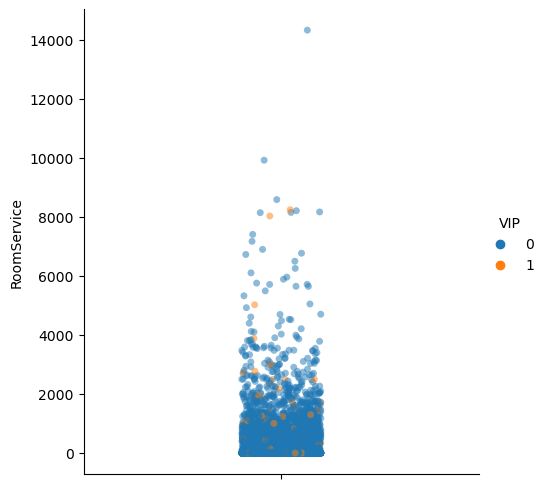

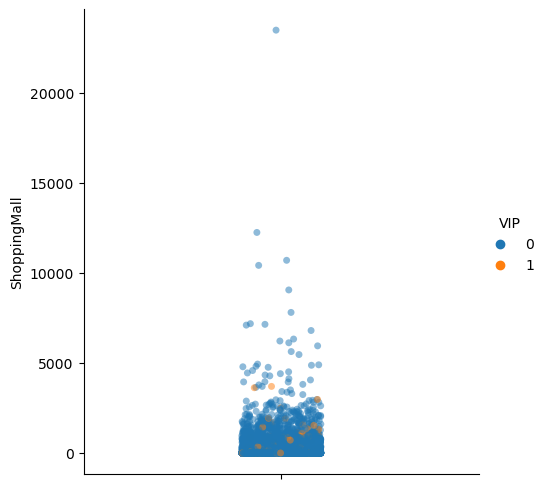

In [49]:
import seaborn as sns

sns.catplot(data=train, y='RoomService', hue='VIP', alpha = 0.5)
sns.catplot(data=train, y='ShoppingMall', hue='VIP', alpha = 0.5)

It seems that VIP status doesn't affect spendings much. Let's look for other correlations, but first let's introduce a feature TotalSpendings:

In [50]:
train['TotalSpendings'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].sum(axis=1)
test['TotalSpendings'] = test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].sum(axis=1)

print(train['TotalSpendings'].info())
train['TotalSpendings'].describe()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None


count     8693.000000
mean      1442.901875
std       2803.065832
min          1.000000
25%          2.000000
50%        718.000000
75%       1443.000000
max      35988.000000
Name: TotalSpendings, dtype: float64

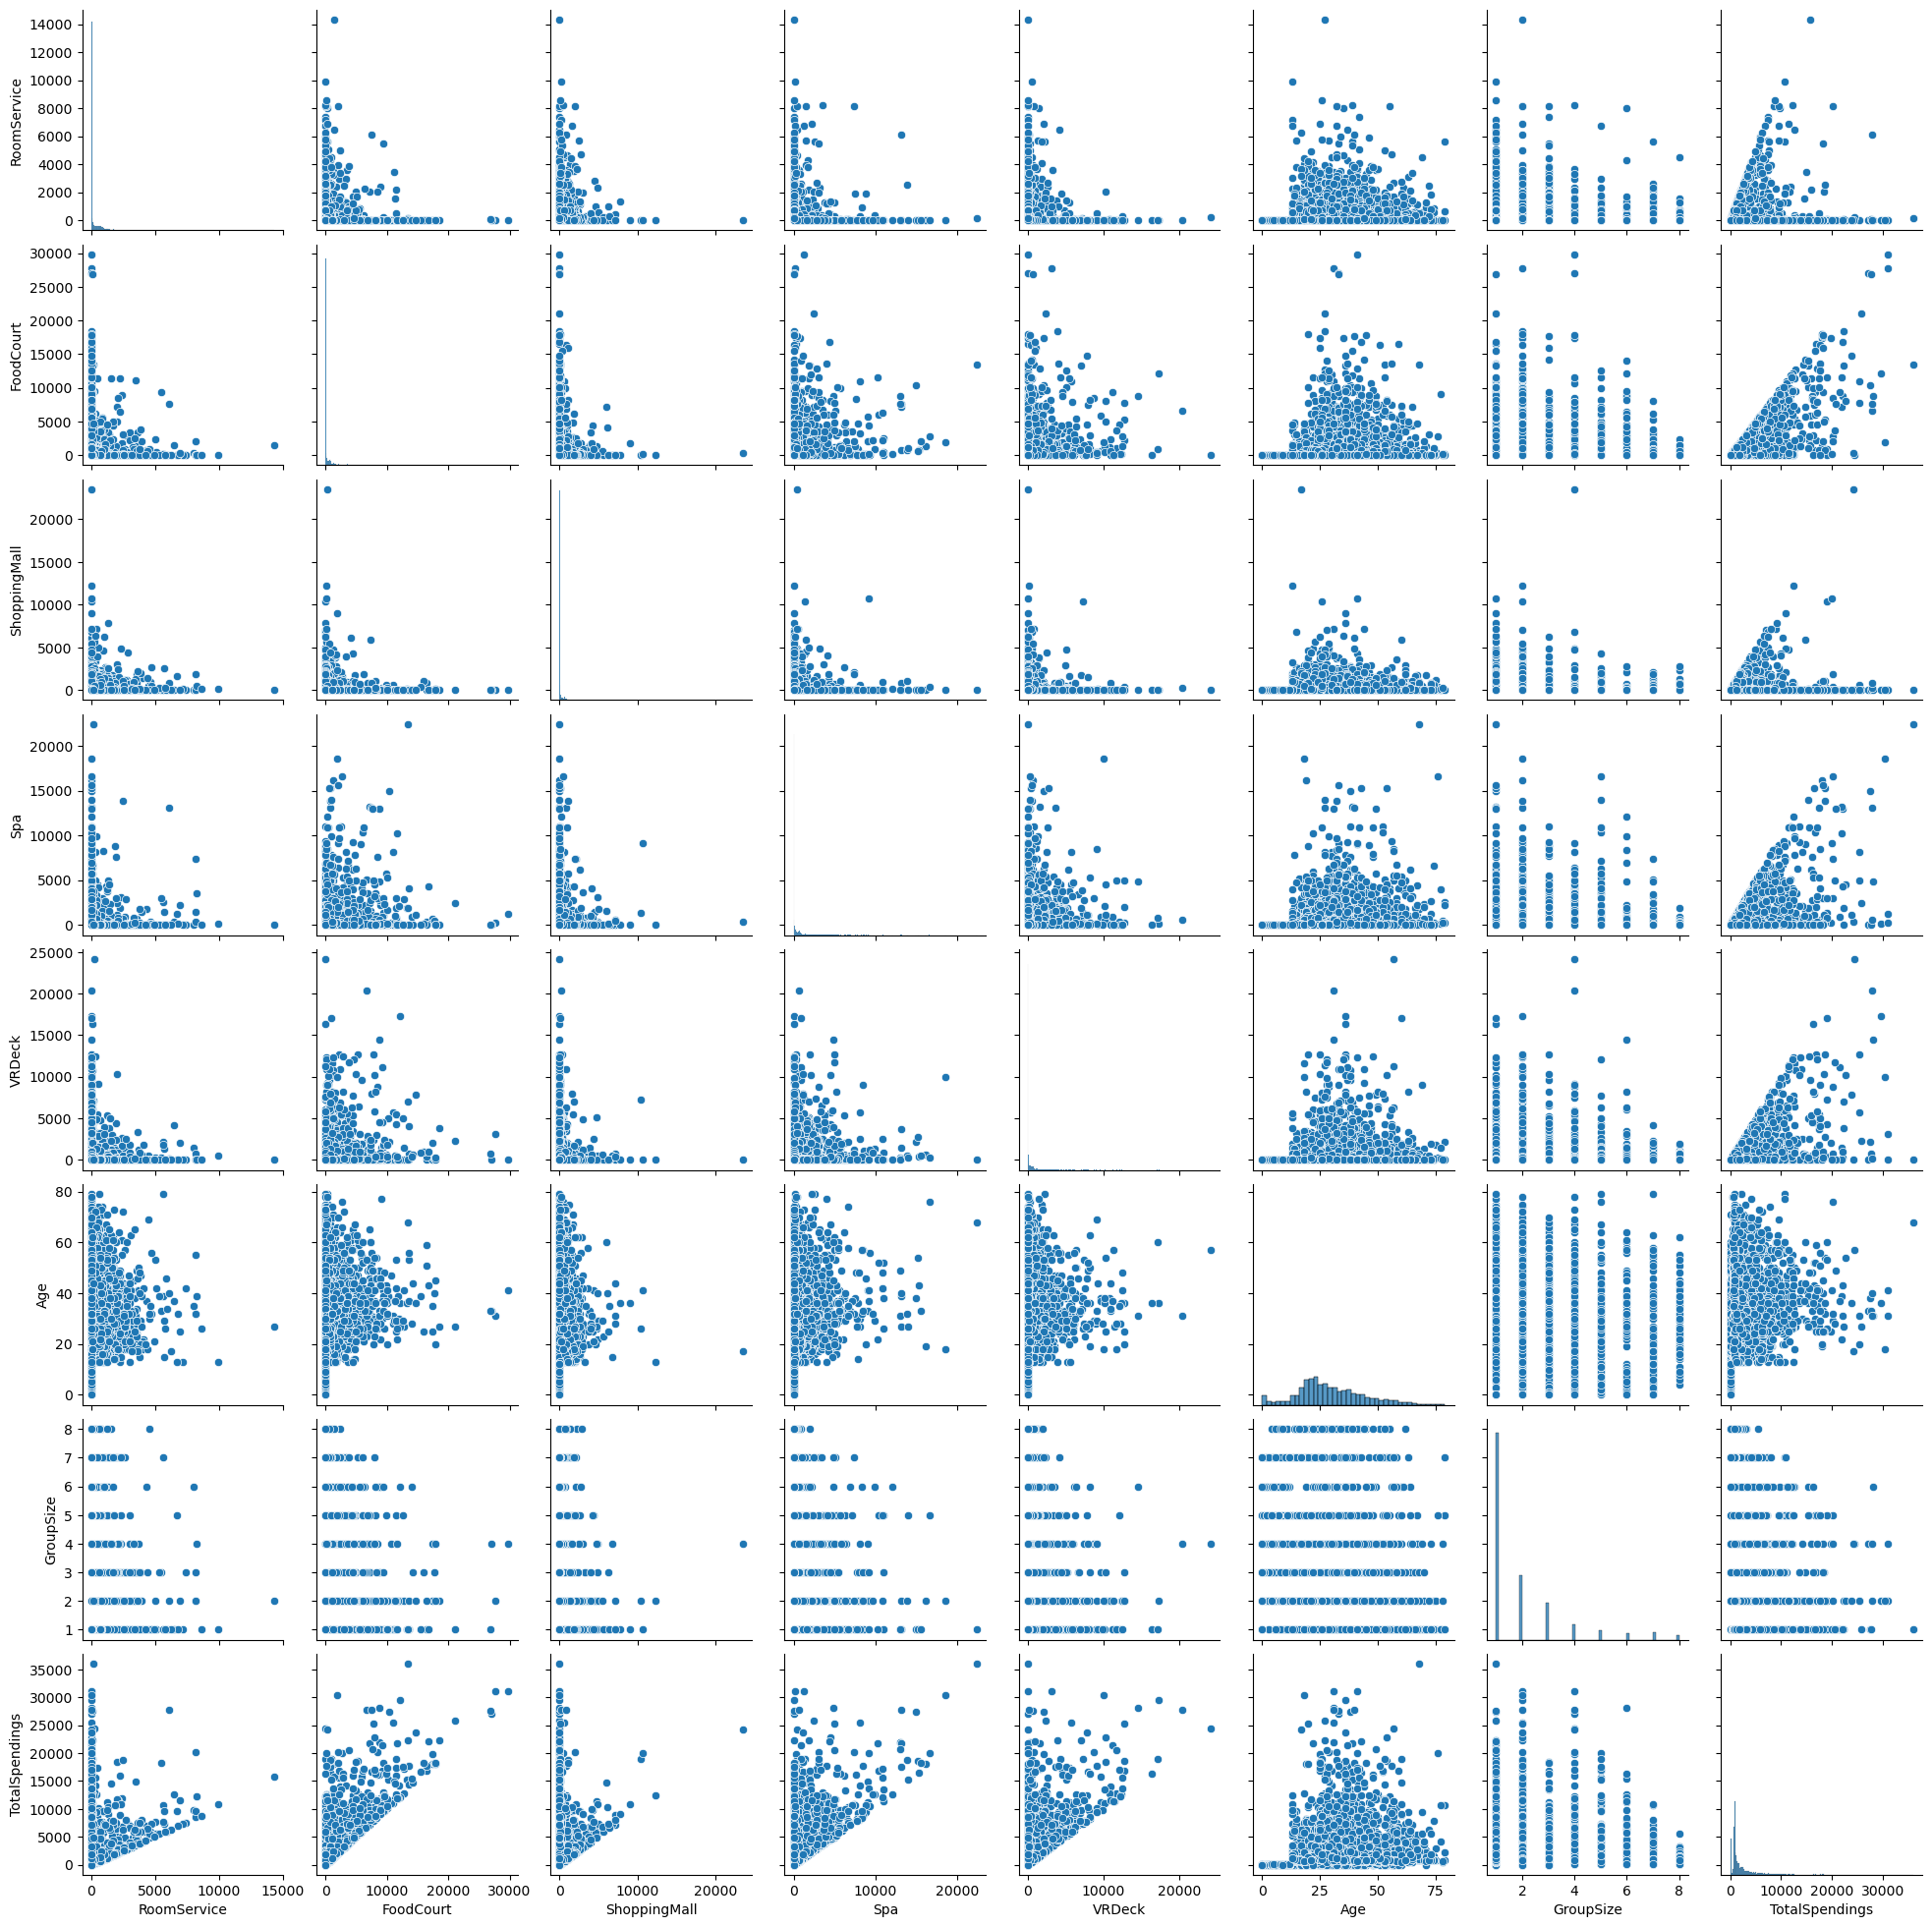

CPU times: total: 14.9 s
Wall time: 15.8 s


In [51]:
%%time

import matplotlib.pyplot as plt

# Plot pairwise relationships
sns.pairplot(train.loc[train['CryoSleep'] == False, ['RoomService', 'FoodCourt', \
                                                    'ShoppingMall', 'Spa', 'VRDeck', \
                                                    'Age', 'GroupSize', 'TotalSpendings']])

# Show plot
plt.show()

First, we see that spendings in different categories don't really corelate with each other or with TotalSpendings.

However, we see that all of them show the same pattern with Age. Let's look at this pattern more closely:

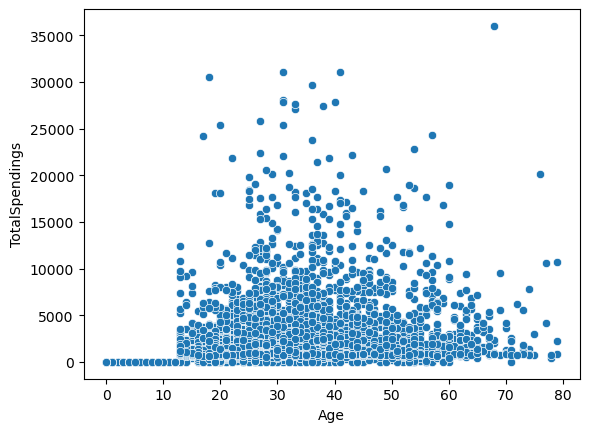

In [52]:
# Plot pairwise relationships
sns.scatterplot(data = train[train['CryoSleep'] == False], x='Age', y='TotalSpendings')

# Show plot
plt.show()

In [53]:
print('Median spendings of kids, teens and adults:')

print(train.loc[train['Age'] < 14, 'TotalSpendings'].median())
print(train.loc[(train['Age'] >= 14) & (train['Age']  <= 19), 'TotalSpendings'].median())
print(train.loc[train['Age'] > 21, 'TotalSpendings'].median())

Median spendings of kids, teens and adults:
3.0
698.0
805.0


We see that kids almost don't spend, and adults spend more than teens.

1) We'll create AgeGroup, with values 0 for kids, 1 for teens and 2 for adults

1) We'll fill missing TotalSpendings according to median TotalSpendings for their AgeGroup (calculated on the train set, to prevent data leakage)

2) Missing spendings per category will be 0, because median spendings per category are 0

3) We'll fill missing Age values according to their TotalSpendings (calculated on the train set, to prevent data leakage)

Let's procceed:

In [54]:
# create AgeGroup, with values 0 for kids, 1 for teens and 2 for adults

for data in [train, test]:
    data['AgeGroup'] = [0 if age < 14 else 1 if (age >= 14) and (age < 21) \
                        else 2 if age >= 21 else np.nan for age in data['Age']]
    print(data['AgeGroup'].info())
    print(data['AgeGroup'].describe())
    print('Unique Values:')
    print(data['AgeGroup'].value_counts())
    

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: AgeGroup
Non-Null Count  Dtype  
--------------  -----  
8514 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count    8514.000000
mean        1.602772
std         0.679669
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: AgeGroup, dtype: float64
Unique Values:
2.0    6079
1.0    1488
0.0     947
Name: AgeGroup, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: AgeGroup
Non-Null Count  Dtype  
--------------  -----  
4186 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count    4186.000000
mean        1.606785
std         0.666087
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: AgeGroup, dtype: float64
Unique Values:
2.0    2969
1.0     788
0.0     429
Name: AgeGroup, dtype: int64


In [55]:
# fill missing TotalSpendings according to median spendings for their AgeGroup

# Save median spendings into variables
median = train['TotalSpendings'].median()
median_by_age_group = {group: train.loc[train["AgeGroup"] == group, 'TotalSpendings'].median() \
                      for group in train["AgeGroup"].dropna().unique()}

print(median_by_age_group)

# If AgeGroup is missing, fill with median spendings for all
train.loc[train['AgeGroup'].isna(), 'TotalSpendings'] = median
test.loc[test['AgeGroup'].isna(), 'TotalSpendings'] = median

# Iterate through all the rows with missing data
for index in train[train['TotalSpendings'].isna()].index:
    # If AgeGroup is present, fill with mean spendings for their AgeGroup
    train.loc[index, 'TotalSpendings'] = median_by_age_group[train.loc[index, 'AgeGroup']]

print(train['TotalSpendings'].info())
print(train['TotalSpendings'].describe())

# Iterate through all the rows with missing data
for index in test[test['TotalSpendings'].isna()].index:
    # If Age is present, fill with mean spendings for their Age
    test.loc[index, 'TotalSpendings'] = median_by_age_group[train.loc[index, 'AgeGroup']]

print(test['TotalSpendings'].info())
print(test['TotalSpendings'].describe())


{2.0: 804.0, 1.0: 707.0, 0.0: 3.0}
<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count     8693.000000
mean      1430.933625
std       2774.836167
min          1.000000
25%          2.000000
50%        718.000000
75%       1419.000000
max      35988.000000
Name: TotalSpendings, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count     4277.000000
mean      1401.775310
std       2779.019097
min          1.000000
25%          2.000000
50%        718.000000
75%       1409.000000
max      33668.000000
Name: TotalSpendings, dtype: float64


In [56]:
#  fill missing Age values according to their TotalSpendings

# Save median ages to a list
median = [train.loc[train['Age'] < 14, 'Age'].median(), train.loc[(train['Age'] > 14) & \
                                                (train['Age']  <= 19), 'Age'].median(),
                                             train.loc[train['Age'] > 21, 'Age'].median()]

for data in [train, test]:

    # Iterate through all the rows with missing data
    for index in data[data['Age'].isna()].index:
        # fill
        if data.loc[index, 'TotalSpendings'] < 698.0:
            data.loc[index, 'Age'] = median[0]
        elif data.loc[index, 'TotalSpendings'] < 805.0:
            data.loc[index, 'Age'] = median[1]
        else:
            data.loc[index, 'Age'] = median[2]


print(train['Age'].info())
print(train['Age'].describe())
print(test['Age'].info())
print(test['Age'].describe())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean       28.604970
std        14.421278
min         0.000000
25%        19.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean       28.431377
std        14.111469
min         0.000000
25%        19.000000
50%        26.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64


In [57]:
# Recalculate AgeGroup

for data in [train, test]:
    data['AgeGroup'] = [0 if age < 14 else 1 if (age >= 14) and (age < 21) \
                        else 2 if age >= 21 else np.nan for age in data['Age']]
    print(data['AgeGroup'].info())
    print(data['AgeGroup'].describe())
    print('Unique Values:')
    print(data['AgeGroup'].value_counts())
    

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: AgeGroup
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        1.590360
std         0.678059
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: AgeGroup, dtype: float64
Unique Values:
2    6079
1    1667
0     947
Name: AgeGroup, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: AgeGroup
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        1.593874
std         0.664755
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: AgeGroup, dtype: float64
Unique Values:
2    2969
1     879
0     429
Name: AgeGroup, dtype: int64


In [58]:
# Fill missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

Great, now we don't have any missing values:

In [59]:
print(train.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             8693 non-null   float64
 1   RoomService     8693 non-null   float64
 2   FoodCourt       8693 non-null   float64
 3   ShoppingMall    8693 non-null   float64
 4   Spa             8693 non-null   float64
 5   VRDeck          8693 non-null   float64
 6   Transported     8693 non-null   int64  
 7   Group           8693 non-null   object 
 8   Group_enc       8693 non-null   float64
 9   GroupSize       8693 non-null   int64  
 10  Name            8693 non-null   object 
 11  FamilySize      8693 non-null   int64  
 12  HomePlanet      8693 non-null   object 
 13  Destination     8693 non-null   object 
 14  VIP             8693 non-null   int64  
 15  Cabin           8693 non-null   object 
 16  CryoSleep       8693 non-null   int64  
 17  Deck            8693 non-null   o

Let's check if this way of filling missing values is more beneficial:

In [60]:

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="New filling of numerical features")
submission.to_csv('submissions/submission_06.csv', index=False)
scores_df.loc[6, 'Test Accuracy'] = np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN


Since our Cross-val score dropped, we won't use this variant of filling.

## 07. Filling Age with median

Let's try to fill missing values for Age with median age in the training test, and the rest of missing values with 0's (since medians are 0's):

In [61]:
# Collect unprocessed "Age" to train and test and fill with medians
train['Age'] = train_unprocessed['Age']
train.loc[train['Age'].isna(), 'Age'] = train['Age'].median()
test['Age'] = test_unprocessed['Age']
test.loc[test['Age'].isna(), 'Age'] = train['Age'].median()

# For each category of spendings
for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    # Collect unprocessed columns to train and test
    train[column] = train_unprocessed[column]
    test[column] = test_unprocessed[column]
    
# Fill the rest of missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             8693 non-null   float64
 1   RoomService     8693 non-null   float64
 2   FoodCourt       8693 non-null   float64
 3   ShoppingMall    8693 non-null   float64
 4   Spa             8693 non-null   float64
 5   VRDeck          8693 non-null   float64
 6   Transported     8693 non-null   int64  
 7   Group           8693 non-null   object 
 8   Group_enc       8693 non-null   float64
 9   GroupSize       8693 non-null   int64  
 10  Name            8693 non-null   object 
 11  FamilySize      8693 non-null   int64  
 12  HomePlanet      8693 non-null   object 
 13  Destination     8693 non-null   object 
 14  VIP             8693 non-null   int64  
 15  Cabin           8693 non-null   object 
 16  CryoSleep       8693 non-null   int64  
 17  Deck            8693 non-null   o

In [62]:
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_07.csv')
test_selected.to_csv('new_datasets/test_07.csv')

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="5 + filled Age with medians")
submission.to_csv('submissions/submission_07.csv', index=False)
scores_df.loc[7, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN


No, our Cross-val Score is still lower than Score from 05, where all the missing numerical values were filled with 0's. We could try some complex inerpolation methods, but, for now, let's just stick with 0's:

In [63]:
# Collect unprocessed "Age" to train and test 
train['Age'] = train_unprocessed['Age']
test['Age'] = test_unprocessed['Age']

# Fill missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_07.csv')
test_selected.to_csv('new_datasets/test_07.csv')

## 08. Tuning of XGBoost

Now, let's tune our XGBoost classifier:

In [64]:
study = joblib.load("studies/08.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

xgb_main_params = study.best_params

Best average cross-validation Score: 0.8914689314240911
Best hyperparameters: {'max_depth': 13, 'max_leaves': 29, 'grow_policy': 'lossguide', 'learning_rate': 0.08, 'booster': 'dart', 'tree_method': 'approx', 'gamma': 1.834861192156488, 'min_child_weight': 0.02502298800121074, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.9}


As always, let's put this into our table:

In [65]:
%%time

# Instantiate the classifier
model = xgb.XGBClassifier(random_state=SEED, n_jobs=-1, **xgb_main_params)

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="5 + XGBoost tuned")
submission.to_csv('submissions/submission_08.csv', index=False)
scores_df.loc[8, 'Test Accuracy'] =  0.80547
scores_df.to_csv('scores_df.csv')
scores_df

CPU times: total: 41.3 s
Wall time: 4.28 s


,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547


After several minutes of tuning, we see improvemets.

## 09. Expensive XGBoost

Now, we can try found hyperparameters with more computationally expensive setup: we'll choose number of estimators in range (50, 500) and add 'exact' tree method as an option. We won't change other parameters:

In [66]:
study = joblib.load("studies/09.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

xgb_extra_params = study.best_params

Best average cross-validation Score: 0.8914689314240911
Best hyperparameters: {'n_estimators': 100, 'tree_method': 'approx'}


In [67]:
%%time

# Change the parameters
model.set_params(**study.best_params)

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="XGBoost expensive")
submission.to_csv('submissions/submission_09.csv', index=False)
scores_df.loc[9, 'Test Accuracy'] =  0.80547
scores_df.to_csv('scores_df.csv')
scores_df



CPU times: total: 38.1 s
Wall time: 3.87 s


,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


 Let's try to tune different classifiers:

## 10. Tuning of Random Forests

In [68]:
study_number = 10

study = joblib.load("studies/{}.pkl".format(study_number))

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

rf_main_params = study.best_params

Best average cross-validation Score: 0.886389433785405
Best hyperparameters: {'criterion': 'log_loss', 'max_depth': 10, 'max_features': 7, 'max_leaf_nodes': 179, 'min_impurity_decrease': 0.0003401170930011726, 'min_samples_leaf': 2, 'ccp_alpha': 1.303617229320636e-05, 'max_samples': 0.8534078600487377}


In [69]:
%%time

# Instantiate the classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=SEED,
                               n_estimators=90,
                               n_jobs=-1,
                               **study.best_params
                               )

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="RandomForests tuned")
submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df



CPU times: total: 734 ms
Wall time: 1.17 s


,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


## 11. Expensive Random Forests

We'll test the found hyperparameters with number of estimators from 50 to 500 and add 'entropy' as an option for measuring quality of split:

In [70]:
study_number = 11

study = joblib.load("studies/{}.pkl".format(study_number))

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

rf_extra_params = study.best_params

Best average cross-validation Score: 0.886389433785405
Best hyperparameters: {'n_estimators': 90, 'criterion': 'log_loss'}


In [71]:
%%time

# Change the parameters
model.set_params(**study.best_params)

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="RandomForests expensive")
submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df



CPU times: total: 922 ms
Wall time: 1.14 s


,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


## 12. Logistic Regression without normalization

Next, we'll try Logistic Regression classifier, without normalizing features (500 iterations maximum):

In [72]:
study_number = 12

study = joblib.load("studies/{}.pkl".format(study_number))

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

lr_params = study.best_params

Best average cross-validation Score: 0.8675462398181004
Best hyperparameters: {'C': 0.017309730489996192, 'solver': 'lbfgs'}


In [73]:
%%time

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=SEED,
                           n_jobs=-1,
                           max_iter =500,
                           **study.best_params
                           )

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="LogisticRegression tuned")
submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

CPU times: total: 1.92 s
Wall time: 3.75 s


,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


## 13. (TODO) Logistic Regression with normalization

In [74]:
study_number = 13

scores_df.loc[study_number, :] =  ['(TODO) Logistic Regression with normalization', \
                                   np.nan, np.nan, np.nan]
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


## Model Ensembling (4 ways)

Next, we'll do model ensembling using 3 of our best estimators. We'll do it in 4 ways:

14) Majority vote
15) Average probablility
16) Naive Stacking
17) Stacking

Let's calculate Scores for way 14 and 15:

In [75]:
%%time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

# Instantiate the best classifiers:
model_xgb = xgb.XGBClassifier(random_state=SEED, n_jobs=-1, **xgb_main_params)
model_xgb.set_params(**xgb_extra_params)

model_rf = RandomForestClassifier(random_state=SEED, n_jobs=-1, **rf_main_params)
model_rf.set_params(**rf_extra_params)

model_lr = LogisticRegression(random_state=SEED, n_jobs=-1, max_iter =500, **lr_params)

# Create a StratifiedKFold object ('n_splits' splits with equal proportion of positive target values)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Empty lists for collecting scores
train_scores_voting = []
train_scores_average = []
cv_scores_voting = []
cv_scores_average = []
cv_accuracy_xgb = []
cv_accuracy_voting = []

# Iterate through folds
for train_index, cv_index in skf.split(train_selected.drop('Transported', axis=1),
                                       train_selected['Transported']):
    # Obtain training and testing folds
    cv_train, cv_test = train_selected.iloc[train_index], train_selected.iloc[cv_index]

    # Fit the models
    model_xgb.fit(cv_train.drop('Transported', axis=1), cv_train['Transported'])
    model_rf.fit(cv_train.drop('Transported', axis=1), cv_train['Transported'])
    model_lr.fit(cv_train.drop('Transported', axis=1), cv_train['Transported'])
    
    # Make predictions on a training set:
    xgb_pred_train = model_xgb.predict(cv_train.drop('Transported', axis=1))
    xgb_pred_train = [True if i == 1 else False for i in xgb_pred_train]
    rf_pred_train = model_rf.predict(cv_train.drop('Transported', axis=1))
    lr_pred_train = model_lr.predict(cv_train.drop('Transported', axis=1))
    
    # Vote
    pred_train_df = pd.DataFrame(list(zip(xgb_pred_train, rf_pred_train, lr_pred_train)))
    pred_train = pred_train_df.mode(axis=1)
    
    # Make probabilistic predictions on a training set:
    xgb_proba_train = model_xgb.predict_proba(cv_train.drop('Transported', axis=1))[:, 1]
    rf_proba_train = model_rf.predict_proba(cv_train.drop('Transported', axis=1))[:, 1]
    lr_proba_train = model_lr.predict_proba(cv_train.drop('Transported', axis=1))[:, 1]
    
    # Calculate average probabilistic prediction on a training set
    proba_train_df = pd.DataFrame(list(zip(xgb_proba_train, rf_proba_train, lr_proba_train)))
    proba_train = proba_train_df.mean(axis=1)
    
    # Make predictions on a cross-val set:
    xgb_pred_cv = model_xgb.predict(cv_test.drop('Transported', axis=1))
    xgb_pred_cv = [True if i == 1 else False for i in xgb_pred_cv]
    rf_pred_cv = model_rf.predict(cv_test.drop('Transported', axis=1))
    lr_pred_cv = model_lr.predict(cv_test.drop('Transported', axis=1))
    
    
    # Vote
    pred_cv_df = pd.DataFrame(list(zip(xgb_pred_cv, rf_pred_cv, lr_pred_cv)))
    pred_cv = pred_cv_df.mode(axis=1)
    
    # Make probabilistic predictions on a cross-val set:
    xgb_proba_cv = model_xgb.predict_proba(cv_test.drop('Transported', axis=1))[:, 1]
    rf_proba_cv = model_rf.predict_proba(cv_test.drop('Transported', axis=1))[:, 1]
    lr_proba_cv = model_lr.predict_proba(cv_test.drop('Transported', axis=1))[:, 1]
    
    # Calculate average probabilistic prediction on a cross-val set
    proba_cv_df = pd.DataFrame(list(zip(xgb_proba_cv, rf_proba_cv, lr_proba_cv)))
    proba_cv = proba_cv_df.mean(axis=1)
    
    # Calculate scores and append to the scores lists
    
    train_scores_voting.append(roc_auc_score(cv_train['Transported'], pred_train))
    train_scores_average.append(roc_auc_score(cv_train['Transported'], proba_train))
    cv_scores_voting.append(roc_auc_score(cv_test['Transported'], pred_cv))
    cv_scores_average.append(roc_auc_score(cv_test['Transported'], proba_cv))

    cv_accuracy_xgb.append(accuracy_score(cv_test['Transported'], xgb_pred_cv))
    cv_accuracy_voting.append(accuracy_score(cv_test['Transported'], pred_cv))
    
# Calculate Scores
train_score_voting = np.mean(train_scores_voting) - np.std(train_scores_voting)
train_score_average = np.mean(train_scores_average) - np.std(train_scores_average)
cross_score_voting = np.mean(cv_scores_voting) - np.std(cv_scores_voting)
cross_score_average = np.mean(cv_scores_average) - np.std(cv_scores_average)

CPU times: total: 47.1 s
Wall time: 11.6 s


## 14. Ensembling with majority vote

Let's look at the Scores for the way 14. Since majority vote ensembling give us only 1's and 0's, not probablilities, it doesn't make sence to compare it to our other models using Cross-val Scores (they are based on ROC AUC), but we can look at the Test Accuracy:

In [76]:
# Fit the models to the whole training set:
model_xgb.fit(train_selected.drop('Transported', axis=1), train_selected['Transported'])
model_rf.fit(train_selected.drop('Transported', axis=1), train_selected['Transported'])
model_lr.fit(train_selected.drop('Transported', axis=1), train_selected['Transported'])


# Make predictions on a test set:
xgb_pred = model_xgb.predict(test_selected)
xgb_pred = [True if i == 1 else False for i in xgb_pred]
rf_pred = model_rf.predict(test_selected)
lr_pred = model_lr.predict(test_selected)

# Vote
pred_df = pd.DataFrame(list(zip(xgb_pred, rf_pred, lr_pred)))
pred = pred_df.mode(axis=1)

# Prepare the submission DataFrame
submission = pd.concat([test_Ids, pred], axis=1)
submission.columns = ['PassengerId', 'Transported']

In [77]:
study_number = 14

scores_df.loc[study_number, :] =  ['Ensembling with majority vote', \
                                   train_score_voting, cross_score_voting, np.nan]
submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  0.80593
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


Indeed, as we predicted, the Cross-Val Score is low, but the Test Accuracy is, actually high.

## 15. Ensembling with average probablity

Let's look at the Scores for the way 15. We''l also prepare a submission file:

In [78]:
# Make probabilistic predictions on a test set:
xgb_pred = model_xgb.predict_proba(test_selected)[:, 1]
rf_pred = model_rf.predict_proba(test_selected)[:, 1]
lr_pred = model_lr.predict_proba(test_selected)[:, 1]

# Calculate average probabilistic prediction
pred_df = pd.DataFrame(list(zip(xgb_pred, rf_pred, lr_pred)))
pred = pred_df.mean(axis=1)

# Convert to True/False
pred = [True if i >= 0.5 else False for i in pred]

# Prepare the submission DataFrame
test_pred = pd.DataFrame(pred, columns=['Transported'])
submission = pd.concat([test_Ids, test_pred], axis=1)

In [79]:
study_number = 15

scores_df.loc[study_number, :] =  ['Ensembling with average probablity', \
                                   train_score_average, cross_score_average, np.nan]
submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  0.80383
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


## 16. Naive Stacking

In this ensembling method our 3 best models will calculate probablities on a whole dataset, and then use another XGBoost classifier will use their predictions as features for training and prediction.

Since we use the whole training dataset for the second-level training dataset, theoretically, we may get over-fitting, i.e., out Test Accuracy may be low.

Let's see:

In [80]:
# Make probabilistic predictions on a training set:
xgb_proba_train = model_xgb.predict_proba(train_selected.drop('Transported', axis=1))[:, 1]
rf_proba_train = model_rf.predict_proba(train_selected.drop('Transported', axis=1))[:, 1]
lr_proba_train = model_lr.predict_proba(train_selected.drop('Transported', axis=1))[:, 1]

# Make probabilistic predictions on a test set:
xgb_pred = model_xgb.predict_proba(test_selected)[:, 1]
rf_pred = model_rf.predict_proba(test_selected)[:, 1]
lr_pred = model_lr.predict_proba(test_selected)[:, 1]


# Create DataFrame with probabilistic predictions and the target column
train_second_level = pd.DataFrame(list(zip(xgb_proba_train, rf_proba_train, lr_proba_train)),
                                  columns=['xgb', 'rf', 'lr'])
train_second_level = pd.concat([train_second_level, train_unprocessed['Transported']], axis=1)

# Create a test DataFrame
test_second_level = pd.DataFrame(list(zip(xgb_pred, rf_pred, lr_pred)), columns=['xgb', 'rf', 'lr'])

train_second_level.tail(10)

,xgb,rf,lr,Transported
8683,0.112057,0.189440,0.208767,False
8684,0.535957,0.540268,0.629664,True
8685,0.867529,0.923999,0.831555,True
8686,0.306668,0.407586,0.874573,False
8687,0.753469,0.820213,0.980868,True
8688,0.524998,0.446516,0.906706,False
8689,0.733536,0.716422,0.719359,False
8690,0.861389,0.887299,0.651470,True
8691,0.036760,0.073442,0.006861,False
8692,0.958943,0.974707,0.948188,True


Now, let's train our second-level classifier and see the scores:

In [81]:
study_number = 16

# Instantiate the classifier
model = xgb.XGBClassifier(random_state=SEED, n_jobs=-1)


train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_second_level,
                                                                   test_second_level,
                                                                   model, scores_df,
                                                                   comment="Naive Stacking")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  0.77811
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


As we predicted, our second-level model overfitted to both training and cross-validation folds, getting low Test Accuracy.

## 17. Stacking

In this chapter we'll use StackingClassifier from sklearn. The differencs from naive stacking is that first-level estimators will be trained and make predictions as in stratified k-fold cross-validations. Then their predictions will be combined for the second-level dataset for the second-level estimator:

In [82]:
%%time

study_number = 17

# List of first-level estimators:
estimators = [('xgb', model_xgb), ('rf', model_rf), ('lr', model_lr)]

# Second-level estimator
final_estimator = xgb.XGBClassifier(random_state=SEED, n_jobs=-1)

# Stacking Classifier with 3-fold stratified cross-validation
from sklearn.ensemble import StackingClassifier
model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=3, n_jobs=-1)


train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_selected,
                                                                   test_selected,
                                                                   model, scores_df,
                                                                   comment="Stacking")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  0.787
scores_df.to_csv('scores_df.csv')
scores_df


CPU times: total: 19.7 s
Wall time: 19.8 s


,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


Proper stacking didn't overfit, but performed worse than some other methods.

## Choosing the best estimator so far

Now, we need to choose our best estimator so far. 

If we just look at the Cross-validation Score, then tuned XGBoost is the best.

However, as we confirmed with Test Accuracy, Ensembling with majority vote can't be evaluated based on our Score, since it involves ROC AUC and requires probabilistic predictions.

Therefore, we shall compare these two models by their average Cross-validation Accuracy:

In [83]:
print('Average Cross-validation Accuracy of XGBoost: {}.'.format(np.mean(cv_accuracy_xgb)))
print('Average Cross-validation Accuracy of Ensembling with majority vote: {}.'.format(np.mean(cv_accuracy_voting)))

Average Cross-validation Accuracy of XGBoost: 0.8032901173556425.
Average Cross-validation Accuracy of Ensembling with majority vote: 0.8047853220520597.


Ensembling with majority vote is slightly better.

## Exporing mispredicted data

Let's look at the passengers that were mispredicted by our best model:

In [84]:
# Fit the models to the whole training set:
model_xgb.fit(train_selected.drop('Transported', axis=1), train_selected['Transported'])
model_rf.fit(train_selected.drop('Transported', axis=1), train_selected['Transported'])
model_lr.fit(train_selected.drop('Transported', axis=1), train_selected['Transported'])

# Make predictions on the training set set:
xgb_pred = model_xgb.predict(train_selected.drop('Transported', axis=1))
xgb_pred = [True if i == 1 else False for i in xgb_pred]
rf_pred = model_rf.predict(train_selected.drop('Transported', axis=1))
lr_pred = model_lr.predict(train_selected.drop('Transported', axis=1))

# Vote
pred_df = pd.DataFrame(list(zip(xgb_pred, rf_pred, lr_pred)))
pred = pred_df.mode(axis=1)

# Create a new column
train['PredictionGroup'] = 'Not Calculated'

# Subset the correctly passengers from the training set

train.loc[(train['Transported'] == pred.iloc[:, 0]) & (train['Transported'] == True), 'PredictionGroup'] = 'Correct'
true_positives = train[(train['Transported'] == pred.iloc[:, 0]) & (train['Transported'] == True)]
train.loc[(train['Transported'] == pred.iloc[:, 0]) & (train['Transported'] == False), 'PredictionGroup'] = 'Correct'
true_negatives = train[(train['Transported'] == pred.iloc[:, 0]) & (train['Transported'] == False)]

# Subset the mispredicted passengers from the training set
train.loc[(train['Transported'] != pred.iloc[:, 0]) & (train['Transported'] == False), 'PredictionGroup']  = 'Incorrect'
false_positives = train[(train['Transported'] != pred.iloc[:, 0]) & (train['Transported'] == False)]
train.loc[(train['Transported'] != pred.iloc[:, 0]) & (train['Transported'] == True), 'PredictionGroup']  = 'Incorrect'
false_negatives = train[(train['Transported'] != pred.iloc[:, 0]) & (train['Transported'] == True)]

print('First rows in False Positives:')
print(false_positives.head())
print('Counts:')
train['PredictionGroup'].value_counts()

First rows in False Positives:
     Age  RoomService  FoodCourt  ShoppingMall  Spa  VRDeck  Transported  \
0   39.0          0.0        0.0           0.0  0.0     0.0            0   
15  31.0         32.0        0.0         876.0  0.0     0.0            0   
21   1.0          0.0        0.0           0.0  0.0     0.0            0   
22  49.0          0.0        0.0           0.0  0.0     0.0            0   
23  29.0          0.0        0.0           0.0  0.0     0.0            0   

   Group  Group_enc  GroupSize  ... Deck_enc              Route Europa Mars  \
0   0001   0.503595          1  ...        1  EuropaTRAPPIST-1e      1    0   
15  0012   0.503595          1  ...        6   EarthTRAPPIST-1e      0    0   
21  0020   0.415388          6  ...        4   EarthTRAPPIST-1e      0    0   
22  0020   0.415388          6  ...        4   Earth55 Cancri e      0    0   
23  0020   0.415388          6  ...        4   Earth55 Cancri e      0    0   

    PSO J318.5-22 TRAPPIST-1e  S Tota

Correct      7246
Incorrect    1447
Name: PredictionGroup, dtype: int64

Let's look at the differences between the correctly predicted and mispredicted passengers:

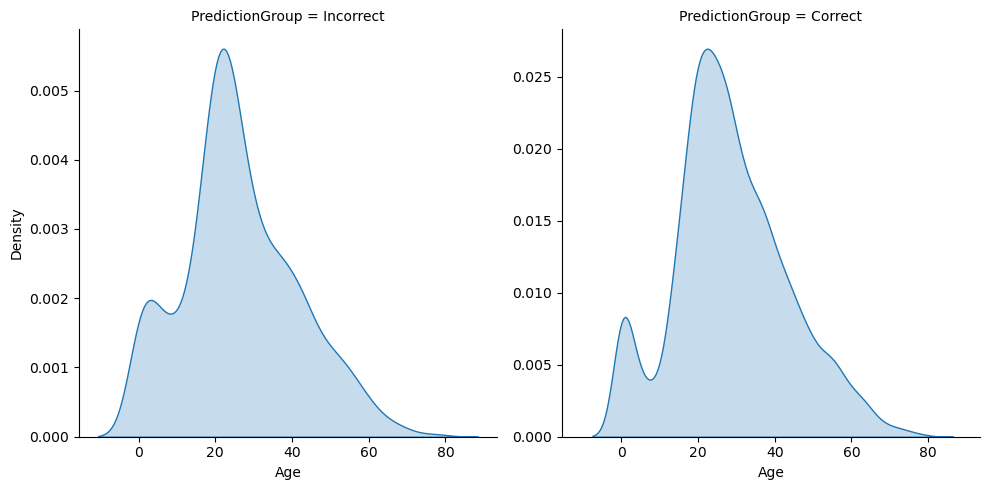

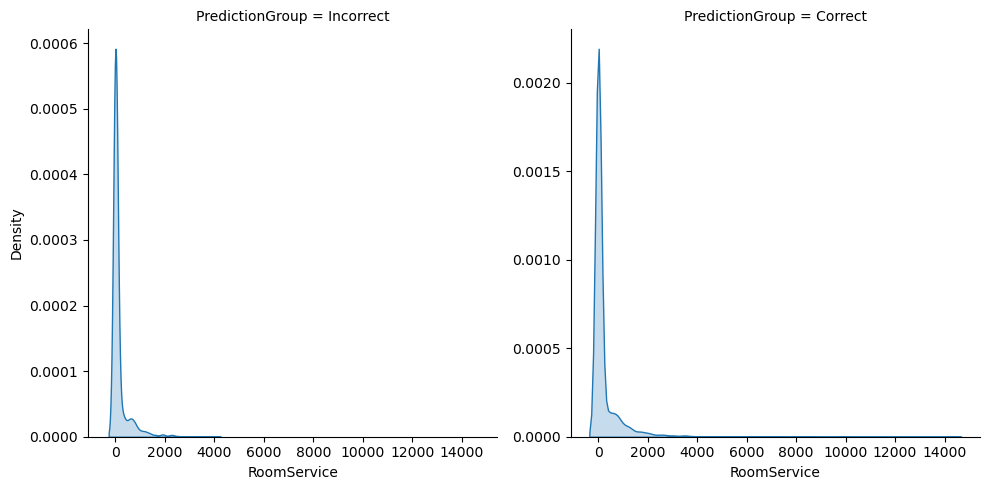

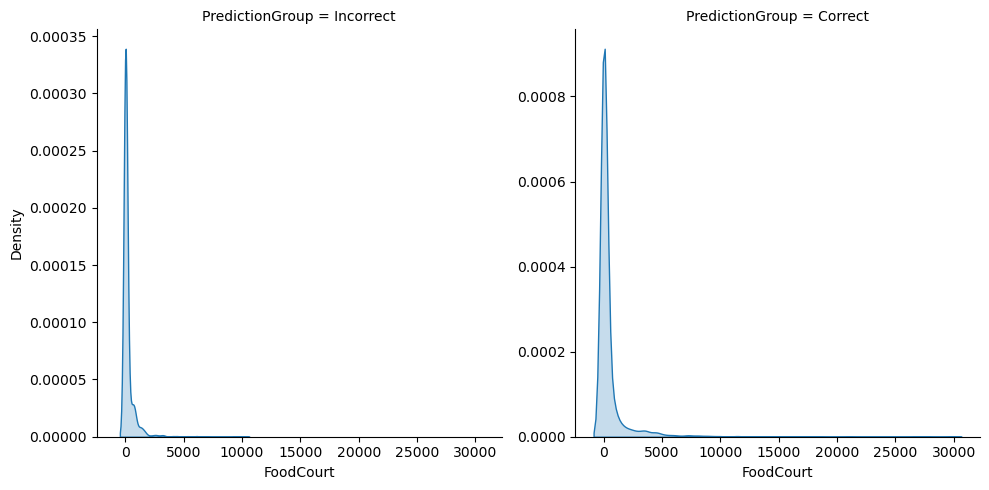

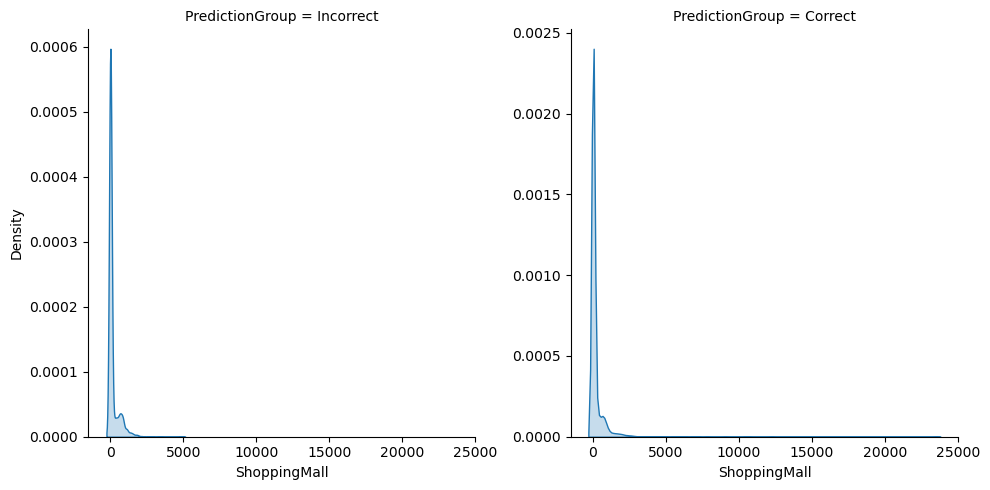

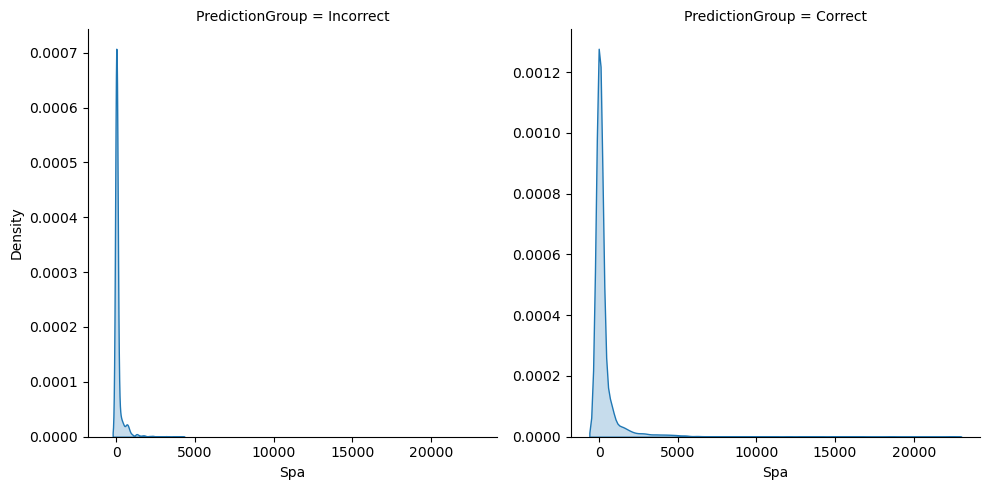

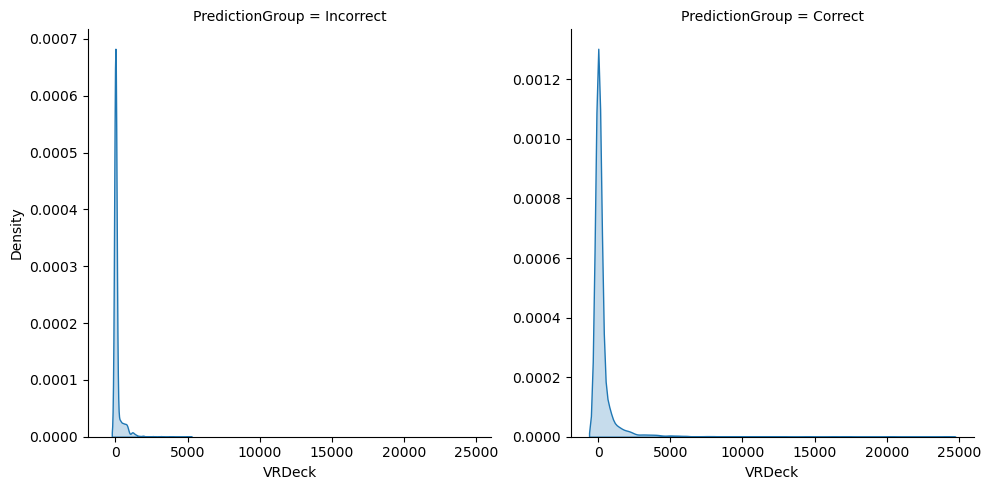

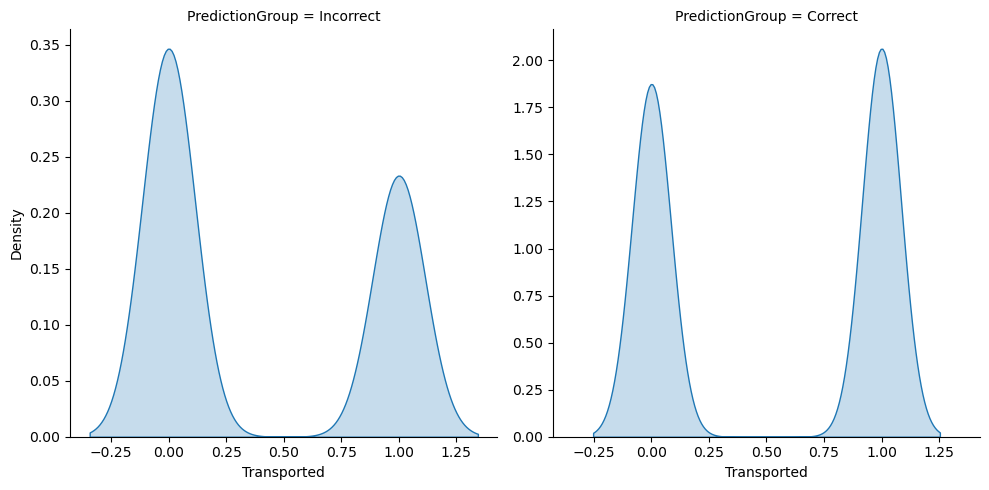

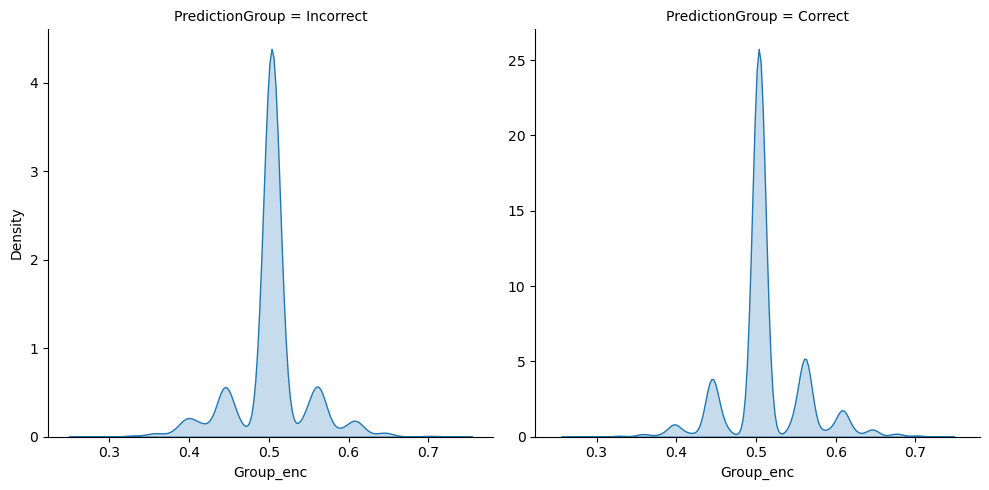

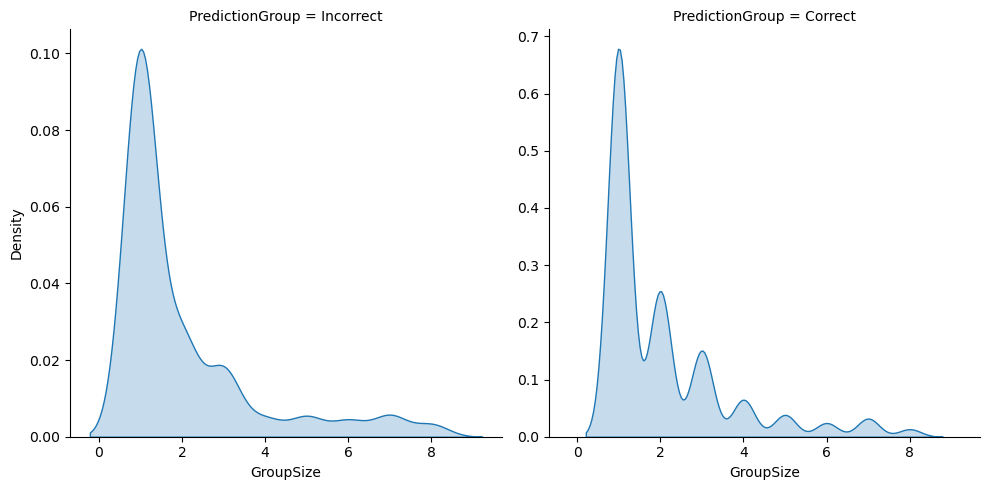

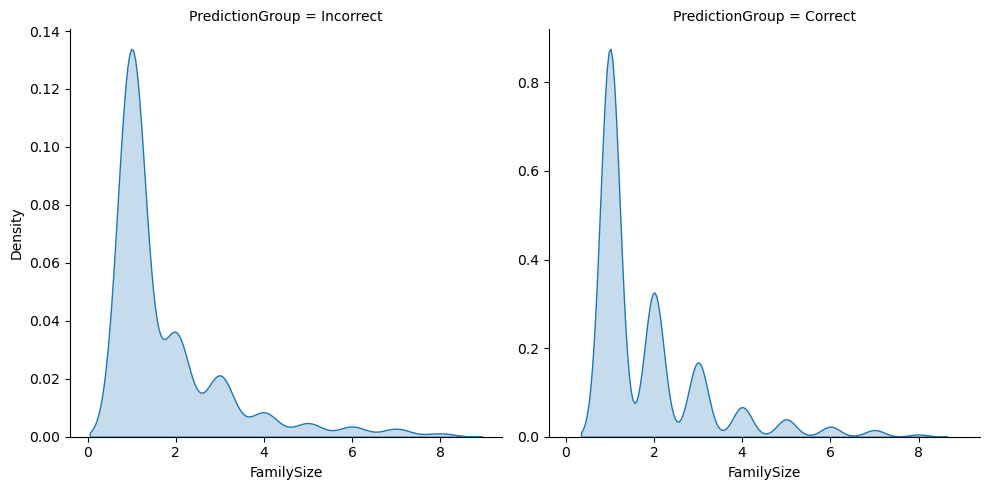

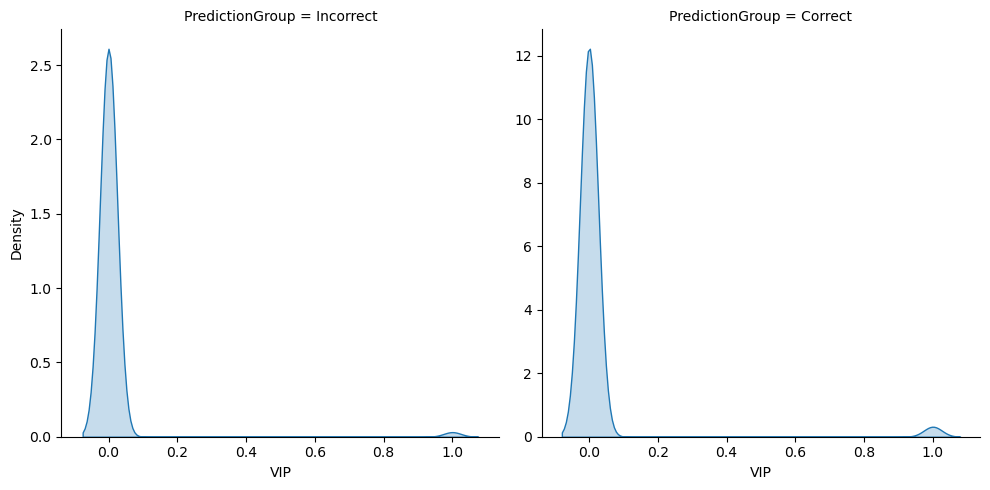

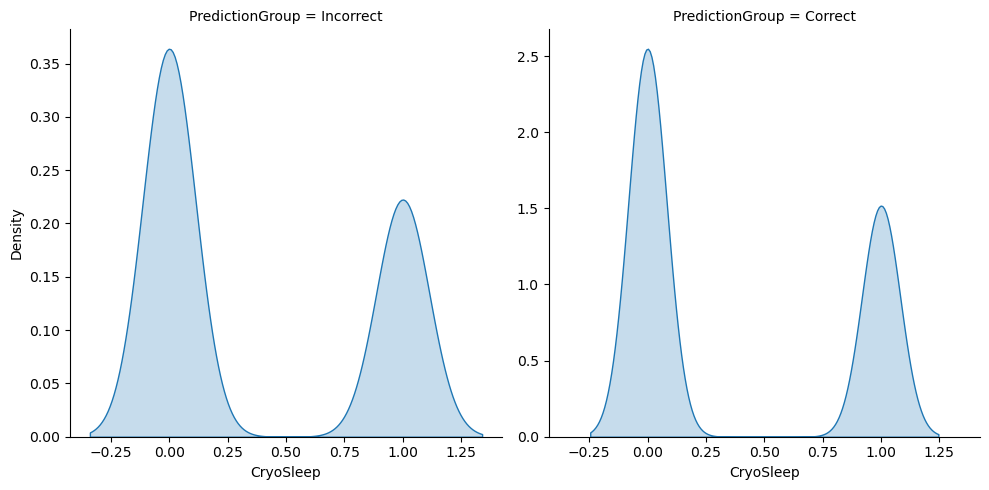

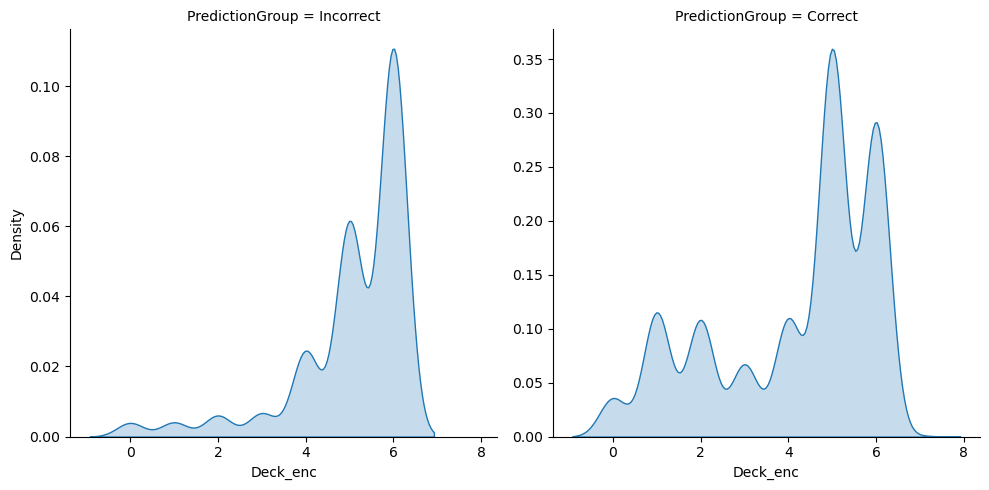

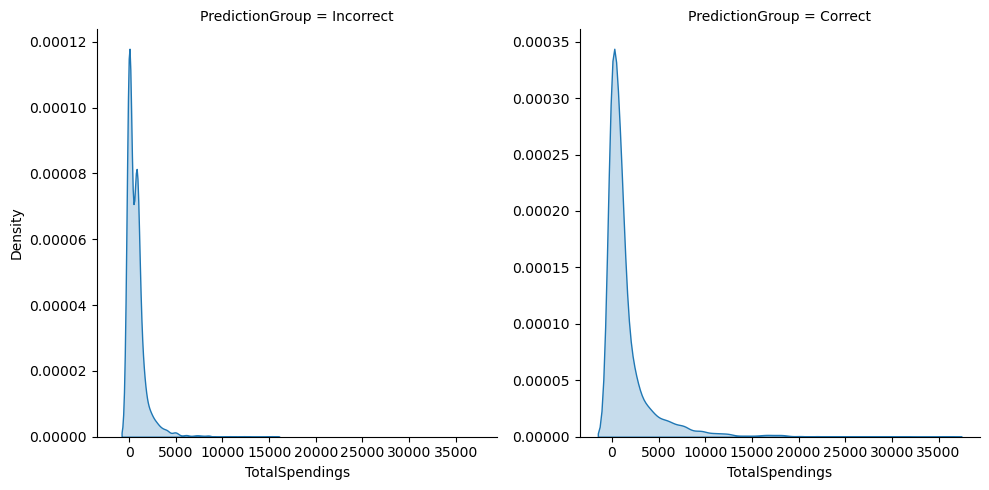

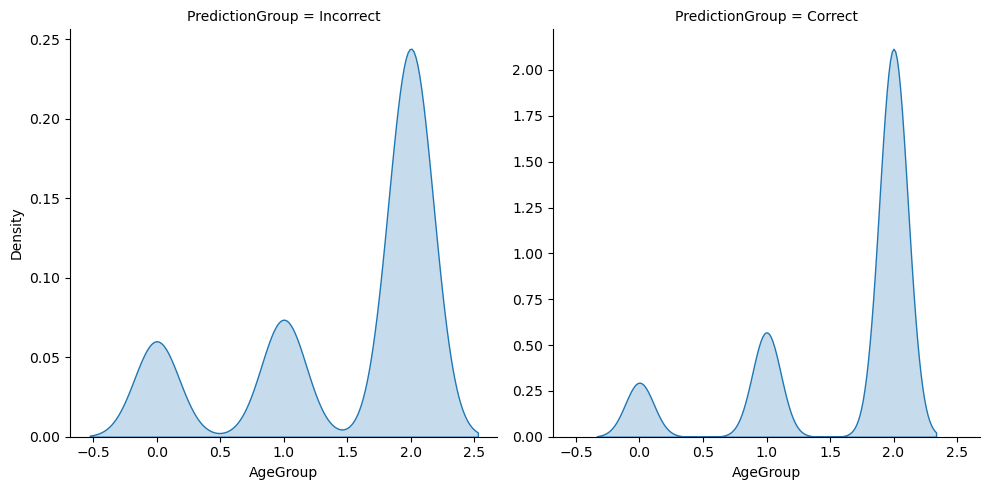

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

for column in train.select_dtypes(include=['int', 'float']).columns:
    sns.displot(data = train, x =column, col='PredictionGroup', kind='kde', fill=True, facet_kws=dict(sharey=False))
    plt.show()
    


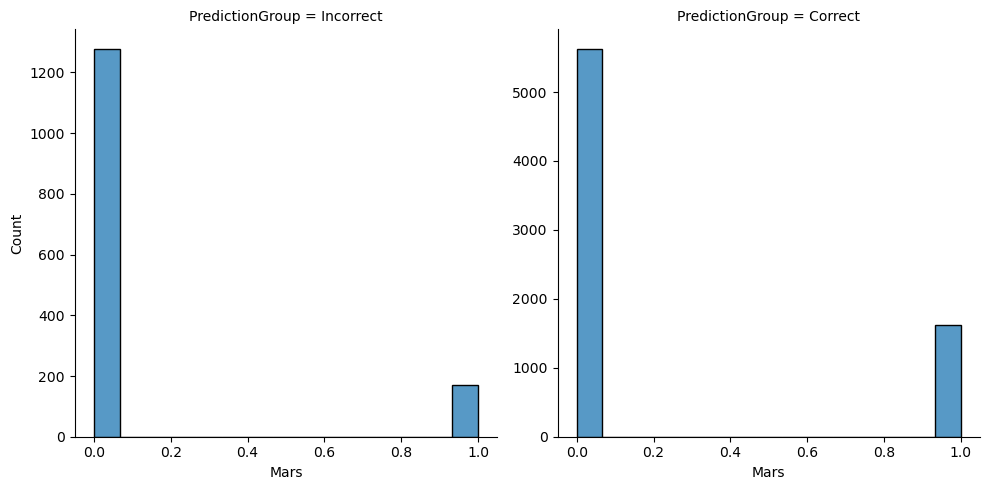

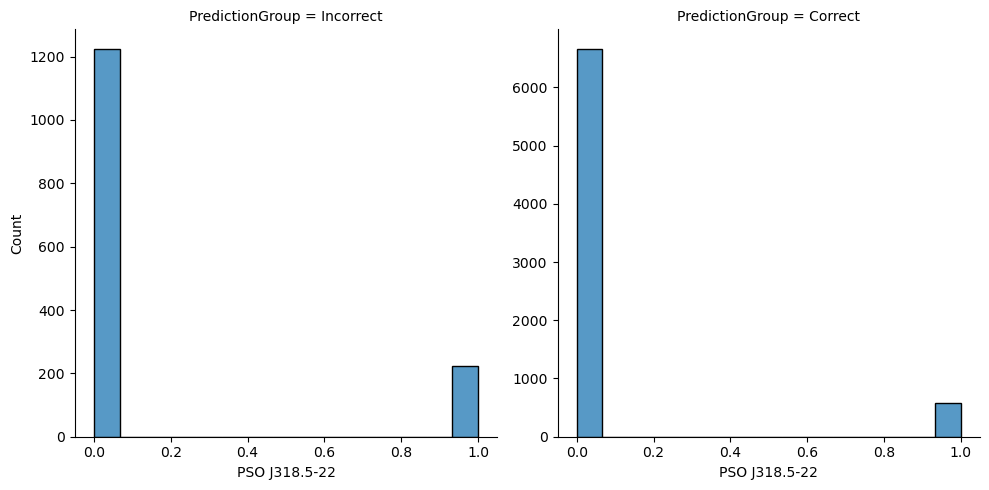

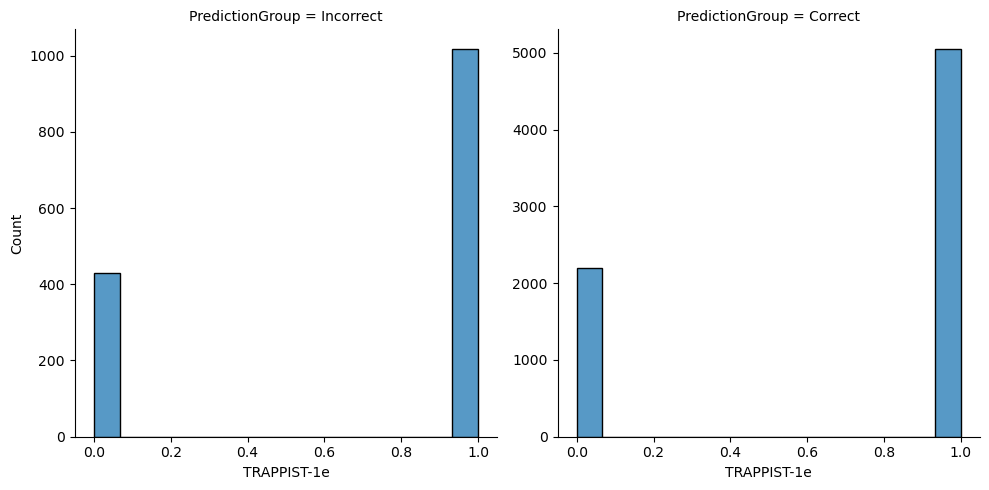

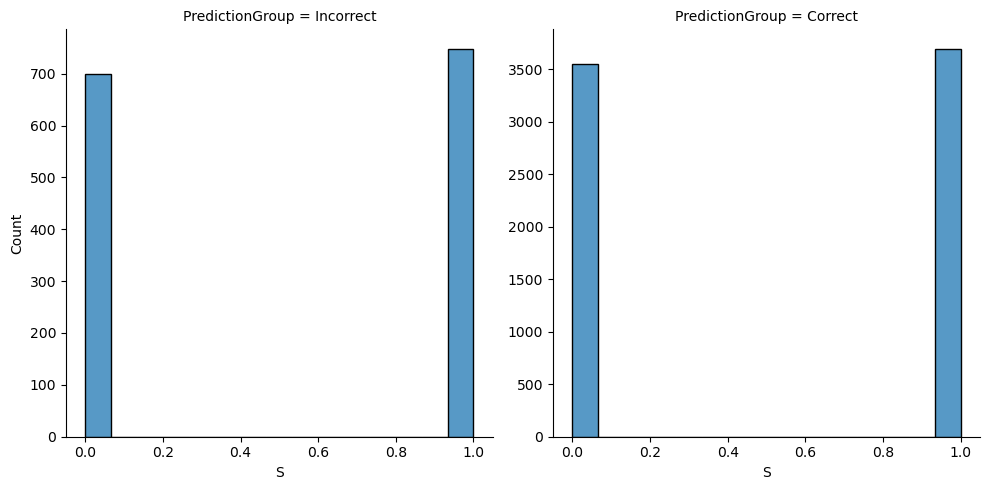

In [86]:
for column in train_selected.select_dtypes(include=['uint8', 'object']).columns:
    sns.displot(data = train, x =column, col='PredictionGroup', kind='hist', fill=True, facet_kws=dict(sharey=False))
    plt.show()

Indeed, there are some patterns. Noticeable differences are in:

18) Age and AgeGroup

19) Spa

20) VRDeck

21) TotalSpendings

22) Deck number

23) Route (and 24)

Let's explore if we can account for these patterns. We'll add new features one-by-one, without removing corresponding old features for now. We'll use the tuned XGBoost for calculating scores, since it's faster, but on;y slightly worse than our best estimator.

## 18. New Age groups

Let's separate ages by half-decade:

In [87]:
study_number = 18
for data in [train, test]:
    data['AgeHalfDecade'] = round(data['Age'] / 5, 0)
    print(data['AgeHalfDecade'].info())
    print(data['AgeHalfDecade'].describe())
    print('Unique Values:')
    print(data['AgeHalfDecade'].value_counts())

    
selected_columns.append('AgeHalfDecade')
    
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_18.csv')
test_selected.to_csv('new_datasets/test_18.csv')

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: AgeHalfDecade
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        5.659611
std         2.991586
min         0.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        16.000000
Name: AgeHalfDecade, dtype: float64
Unique Values:
4.0     1492
5.0     1386
6.0     1081
7.0      852
3.0      739
8.0      675
9.0      517
0.0      499
10.0     340
11.0     290
1.0      271
2.0      215
12.0     174
13.0      98
14.0      38
15.0      20
16.0       6
Name: AgeHalfDecade, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: AgeHalfDecade
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        5.621230
std         2.926301
min         0.000000
25%     

In [88]:
%%time

# Instantiate the classifier
model = xgb.XGBClassifier(random_state=SEED, n_jobs=-1, **xgb_main_params)

train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_selected,
                                                                   test_selected,
                                                                   model, scores_df,
                                                                   comment="8 + AgeHalfDecade")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

CPU times: total: 40.5 s
Wall time: 5.58 s


,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


You can see that the Cross-val score for the row 18 is lower, than for the row 8, so we won't use this feature:

In [89]:
selected_columns.remove('AgeHalfDecade')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_18.csv')
test_selected.to_csv('new_datasets/test_18.csv')

## 19. Spa Usage

We'll create a binary variable with 1's for those who use Spa:

In [90]:
study_number = 19
for data in [train, test]:
    data['SpaUsage'] = [1 if i > 0 else 0 for i in data['Spa']]
    print(data['SpaUsage'].info())
    print(data['SpaUsage'].describe())
    print('Unique Values:')
    print(data['SpaUsage'].value_counts())

    
selected_columns.append('SpaUsage')
    
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_19.csv')
test_selected.to_csv('new_datasets/test_19.csv')

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: SpaUsage
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        0.366502
std         0.481876
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: SpaUsage, dtype: float64
Unique Values:
0    5507
1    3186
Name: SpaUsage, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: SpaUsage
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        0.365911
std         0.481741
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: SpaUsage, dtype: float64
Unique Values:
0    2712
1    1565
Name: SpaUsage, dtype: int64


In [91]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_selected,
                                                                   test_selected,
                                                                   model, scores_df,
                                                                   comment="8 + SpaUsage")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


You can see that the Cross-val score for the row 19 is lower, than for the row 8, so we won't use this feature:

In [92]:
selected_columns.remove('SpaUsage')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_{}.csv'.format(study_number))

## 20 VR Usage

We'll create a binary variable with 1's for those who use VRDeck:

In [93]:
study_number = 20
for data in [train, test]:
    data['VRUsage'] = [1 if i > 0 else 0 for i in data['VRDeck']]
    print(data['VRUsage'].info())
    print(data['VRUsage'].describe())
    print('Unique Values:')
    print(data['VRUsage'].value_counts())

    
selected_columns.append('VRUsage')
    
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_20.csv')
test_selected.to_csv('new_datasets/test_20.csv')

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: VRUsage
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        0.346256
std         0.475803
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: VRUsage, dtype: float64
Unique Values:
0    5683
1    3010
Name: VRUsage, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: VRUsage
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        0.336685
std         0.472631
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: VRUsage, dtype: float64
Unique Values:
0    2837
1    1440
Name: VRUsage, dtype: int64


In [94]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_selected,
                                                                   test_selected,
                                                                   model, scores_df,
                                                                   comment="8 + VRUsage")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


You can see that the Cross-val score for the row 20 is lower, than for the row 8, so we won't use this feature:

In [95]:
selected_columns.remove('VRUsage')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_{}.csv'.format(study_number))

## 21. Total Spendings

Let's look closer at the distributions of total spendings:

In [96]:
train['TotalSpendings'].describe()

count     8693.000000
mean      1430.933625
std       2774.836167
min          1.000000
25%          2.000000
50%        718.000000
75%       1419.000000
max      35988.000000
Name: TotalSpendings, dtype: float64

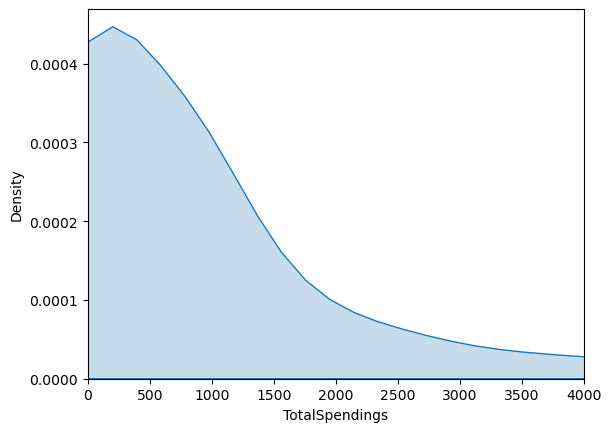

In [97]:
fig, ax = plt.subplots()
sns.kdeplot(data = train, x ='TotalSpendings', fill=True, ax=ax)
ax.set_xlim([0, 4000])
plt.show()

Let's create a numerical feature TotalSpendingsGroup:

In [98]:
# Specify the boundaries of the bins
bins = [-np.inf, 0.01, 500, 1000, 1500, 2000, np.inf]

# Bin labels
labels = [0, 1, 2, 3, 4, 5]

# Bin TotalSpendings using the boundaries
train['TotalSpendingsGroup'] = pd.cut(train['TotalSpendings'], bins, labels=labels)
train['TotalSpendingsGroup'] = train['TotalSpendingsGroup'].astype('int')
test['TotalSpendingsGroup'] = pd.cut(test['TotalSpendings'], bins, labels=labels)
test['TotalSpendingsGroup'] = test['TotalSpendingsGroup'].astype('int')

# Print the first 5 rows of the binned column
print(train[['TotalSpendings', 'TotalSpendingsGroup']].head())

print('Unique values:')
train['TotalSpendingsGroup'].value_counts()

   TotalSpendings  TotalSpendingsGroup
0             1.0                    1
1           737.0                    2
2         10385.0                    5
3          5178.0                    5
4          1092.0                    3
Unique values:


1    3668
2    2240
5    1645
3     699
4     441
Name: TotalSpendingsGroup, dtype: int64

In [99]:
study_number = 21

selected_columns.append('TotalSpendingsGroup')
    
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_21.csv'.format(study_number))

train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_selected,
                                                                   test_selected,
                                                                   model, scores_df,
                                                                   comment="8 + TotalSpendingsGroup")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


You can see that the Cross-val score for the row 21 is lower, than for the row 8, so we won't use this feature:

In [100]:
selected_columns.remove('TotalSpendingsGroup')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_{}.csv'.format(study_number))

## 22. ShipPart

The feature ShipPart will be 0's for those whose Deck < 4 and 1's for rest:

In [101]:
study_number = 22

#Calculate means on the training set
for data in [train, test]:
    data['ShipPart'] = [0 if i < 4 else 1 for i in data['Deck_enc']]
    print(data['ShipPart'].info())
    print(data['ShipPart'].describe())
    print('Unique Values:')
    print(data['ShipPart'].value_counts())

selected_columns.append('ShipPart')
    
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_{}.csv'.format(study_number))

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: ShipPart
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        0.734729
std         0.441503
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: ShipPart, dtype: float64
Unique Values:
1    6387
0    2306
Name: ShipPart, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: ShipPart
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        0.750292
std         0.432894
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: ShipPart, dtype: float64
Unique Values:
1    3209
0    1068
Name: ShipPart, dtype: int64


In [102]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_selected,
                                                                   test_selected,
                                                                   model, scores_df,
                                                                   comment="8 + ShipPart")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


You can see that the Cross-val score for the row 22 is lower, than for the row 8, so we won't use this feature:

In [103]:
selected_columns.remove('ShipPart')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_{}.csv'.format(study_number))

## 23. RouteLenght

Both destinations and home planets have differences in distributions between mispredicted and correctly predicted passengers.

Therefore, we shall try to count for Route, a combination of HomePlanet and destination. 

There are two ways in which we can do so:

23) Create RouteLenght, a proportion of passengers in CryoSleep for this Route (based on the training set)

24) Use dummy variables for Route feature

We'll start with RouteLength:

In [104]:
study_number = 23

#Calculate means on the training set
route_lenghts = train.groupby('Route')['CryoSleep'].mean()

for data in [train, test]:
    data['RouteLength'] = data['Route'].map(route_lenghts)
    print(data['RouteLength'].info())
    print(data['RouteLength'].describe())
    print('Unique Values:')
    print(data['RouteLength'].value_counts())

    
selected_columns.append('RouteLength')
    
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_{}.csv'.format(study_number))

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: RouteLength
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        0.374324
std         0.089662
min         0.260000
25%         0.282549
50%         0.403395
75%         0.407792
max         0.527072
Name: RouteLength, dtype: float64
Unique Values:
0.282549    3295
0.407792    1540
0.403395    1237
0.527072     905
0.517663     736
0.324930     714
0.426396     197
0.260000      50
0.473684      19
Name: RouteLength, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: RouteLength
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        0.374370
std         0.089670
min         0.260000
25%         0.282549
50%         0.403395
75%         0.407792
max         0.527072


In [105]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_selected,
                                                                   test_selected,
                                                                   model, scores_df,
                                                                   comment="8 + RouteLength")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


You can see that the Cross-val score for the row 23 is lower, than for the row 8, so we won't use this feature:

In [106]:
selected_columns.remove('RouteLength')

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_{}.csv'.format(study_number))

## 24) Use dummy variables for Route feature

Let's try to treat Route as a categorical feature:

In [107]:
study_number = 24

dummies = pd.get_dummies(train['Route'], drop_first=True)
train = pd.concat([train, dummies], axis = 1)
dummies = pd.get_dummies(test['Route'], drop_first=True)
test = pd.concat([test, dummies], axis = 1)

train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Group_enc,GroupSize,...,ShipPart,RouteLength,EarthPSO J318.5-22,EarthTRAPPIST-1e,Europa55 Cancri e,EuropaPSO J318.5-22,EuropaTRAPPIST-1e,Mars55 Cancri e,MarsPSO J318.5-22,MarsTRAPPIST-1e
0,39.0,0.0,0.0,0.0,0.0,0.0,0,0001,0.503595,1,...,0,0.403395,0,0,0,0,1,0,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0002,0.503595,1,...,1,0.282549,0,1,0,0,0,0,0,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0003,0.444412,2,...,0,0.403395,0,0,0,0,1,0,0,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0003,0.444349,2,...,0,0.403395,0,0,0,0,1,0,0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,0004,0.503666,1,...,1,0.282549,0,1,0,0,0,0,0,0


In [108]:
selected_columns = selected_columns + list(dummies.columns)
    
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_selected.to_csv('new_datasets/test_{}.csv'.format(study_number))

In [109]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_selected,
                                                                   test_selected,
                                                                   model, scores_df,
                                                                   comment="8 + Route dummies")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


Nope, that didn't work. We have to use our old feature set:

In [110]:
train_selected = pd.read_csv('new_datasets/train_07.csv', index_col=0)
test_selected = pd.read_csv('new_datasets/test_07.csv', index_col=0)

print(train_selected.head())
test_selected.head()

    Age  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  CryoSleep  \
0  39.0          0.0        0.0           0.0     0.0     0.0          0   
1  24.0        109.0        9.0          25.0   549.0    44.0          0   
2  58.0         43.0     3576.0           0.0  6715.0    49.0          0   
3  33.0          0.0     1283.0         371.0  3329.0   193.0          0   
4  16.0        303.0       70.0         151.0   565.0     2.0          0   

   Deck_enc  Mars  PSO J318.5-22  TRAPPIST-1e  S  GroupSize  VIP  Transported  
0         1     0              0            1  0          1    0        False  
1         5     0              0            1  1          1    0         True  
2         0     0              0            1  1          2    1        False  
3         0     0              0            1  1          2    0        False  
4         5     0              0            1  1          1    0         True  


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,Deck_enc,Mars,PSO J318.5-22,TRAPPIST-1e,S,GroupSize,VIP
0,27.0,0.0,0.0,0.0,0.0,0.0,1,6,0,0,1,1,1,0
1,19.0,0.0,9.0,0.0,2823.0,0.0,0,5,0,0,1,1,1,0
2,31.0,0.0,0.0,0.0,0.0,0.0,1,2,0,0,0,1,1,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,0,2,0,0,1,1,1,0
4,20.0,10.0,0.0,635.0,0.0,0.0,0,5,0,0,1,1,1,0


## 25. Learning with missing values.

XGBoost supports learning with missing values. Let's try this:

In [111]:
%%time

study_number = 25

# Copy datasets
train_with_missing = train_selected.copy(deep=True)
test_with_missing = test_selected.copy(deep=True)

# Fill missing values back
for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VIP', 'CryoSleep', 'Age']:
    train_with_missing[column] = train_unprocessed[column]
    test_with_missing[column] = test_unprocessed[column]
    
for column in ['VIP', 'CryoSleep']:
    train_with_missing.loc[train_with_missing[column].notna(), column] = \
                 [1 if i else 0 for i in train_with_missing.loc[train_with_missing[column].notna(), column]]
    train_with_missing[column] = \
                train_with_missing[column].astype('Int64')
    test_with_missing.loc[test_with_missing[column].notna(), column] = \
                 [1 if i else 0 for i in test_with_missing.loc[test_with_missing[column].notna(), column]]
    test_with_missing[column] = \
                test_with_missing[column].astype('Int64')
    
for column in ['Mars']:
    train_with_missing.loc[train_unprocessed['HomePlanet'].isna(), column] = np.nan
    test_with_missing.loc[test_unprocessed['HomePlanet'].isna(), column] = np.nan

for column in ['PSO J318.5-22', 'TRAPPIST-1e']:
    train_with_missing.loc[train_unprocessed['Destination'].isna(), column] = np.nan
    test_with_missing.loc[test_unprocessed['Destination'].isna(), column] = np.nan
    
train_with_missing.loc[train_unprocessed['Cabin'].isna(), 'S'] = np.nan
test_with_missing.loc[test_unprocessed['Cabin'].isna(), 'S'] = np.nan
    
train_with_missing.to_csv('new_datasets/train_{}.csv'.format(study_number))
test_with_missing.to_csv('new_datasets/test_{}.csv'.format(study_number))

train_with_missing[train_with_missing.isnull().values].head(20)


CPU times: total: 78.1 ms
Wall time: 109 ms


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,Deck_enc,Mars,PSO J318.5-22,TRAPPIST-1e,S,GroupSize,VIP,Transported
10,34.0,0.0,0.0,NaN,0.0,0.0,1,1,0.0,0.0,1.0,0.0,3,0,True
15,31.0,32.0,0.0,876.0,0.0,0.0,0,6,0.0,0.0,1.0,NaN,1,0,False
16,27.0,1286.0,122.0,NaN,0.0,0.0,0,5,1.0,0.0,0.0,0.0,1,0,False
23,29.0,0.0,0.0,NaN,0.0,0.0,1,4,0.0,0.0,0.0,1.0,6,0,False
25,1.0,NaN,0.0,0.0,0.0,0.0,1,4,0.0,1.0,0.0,1.0,6,0,False
28,62.0,0.0,0.0,NaN,0.0,0.0,1,2,0.0,0.0,1.0,1.0,1,0,True
35,20.0,NaN,0.0,1750.0,990.0,0.0,0,5,1.0,0.0,1.0,0.0,3,0,True
38,15.0,0.0,492.0,48.0,20.0,401.0,0,5,0.0,0.0,0.0,1.0,1,<NA>,False
40,30.0,0.0,0.0,NaN,0.0,0.0,1,6,0.0,0.0,0.0,0.0,1,0,False
47,19.0,0.0,0.0,0.0,0.0,0.0,1,5,1.0,NaN,NaN,0.0,2,0,True


In [112]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables,
                                                                   train_with_missing,
                                                                   test_with_missing,
                                                                   model, scores_df,
                                                                   comment="XGBoost with NaNs")

submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  np.nan
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.79027
2,All numerical features are selected,0.919507,0.828452,0.79027
3,+ GroupSize,0.932251,0.834209,NaN
4,+ FamilySize,0.935245,0.834230,NaN
5,+ Almost all categorical features,0.974758,0.881800,0.79798
6,New filling of numerical features,0.972632,0.880664,NaN
7,5 + filled Age with medians,0.973565,0.880478,NaN
8,5 + XGBoost tuned,0.935941,0.891469,0.80547
9,XGBoost expensive,0.935941,0.891469,0.80547


## Conclusion

 Let's examine how far we are from the best results. We'll ignore the first 3 places, since their scores are way far away from the 4th place, most probably, due to overfitting to the test data:

In [115]:
correct_passengers = round(len(test_unprocessed) * 0.80593, 1)
correct_passengers_amber = round(len(test_unprocessed) * 0.82557, 1)

print('We labeled correctly {} passengers.'.format(correct_passengers))
print('AmberLi456 (4th place) labeled correctly {} passengers.'.format(correct_passengers_amber))
      
print('Difference is {} passengers.'.format(correct_passengers_amber - correct_passengers))
print('Percentage difference is {} %'.format(round((0.82557 - 0.80593) * 100, 1)))

print('We are in top {}% among all teams (at 2023-08-01)!'.format(round(355/2434 * 100)))

We labeled correctly 3447.0 passengers.
AmberLi456 (4th place) labeled correctly 3531.0 passengers.
Difference is 84.0 passengers.
Percentage difference is 2.0 %
We are in top 15% among all teams (at 2023-08-01)!


What can we do to catch the missed 2%? There are few possible ways:


-) Normalize data for Linear Regression estimator and re-tune it

-) Try more elaborate, automated methods for filling missing values

-) Try different estimators and ensemble them 
